#### Библиотеки

In [21]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox, boxcox_normmax
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import time

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM
from arch import arch_model
from prophet import Prophet
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.gofplots import qqplot
from tbats import TBATS

warnings.filterwarnings('ignore')

#### Предобработка и преобразования

In [12]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df = df.sort_index()
    return df

def log_transform(data):
    if (data > 0).all():
        return np.log(data)
    else:
        return data

def boxcox_transform(data):
    lambda_val = boxcox_normmax(data, brack=(-2, 2))
    data_bc = boxcox(data, lmbda=lambda_val)
    return pd.Series(data_bc, index=data.index), lambda_val

def apply_differencing(data, s=None):
    results = {}
    
    diff1 = data.diff().dropna()
    results['diff1'] = diff1
    
    if s is not None:
        diff_s = data.diff(s).dropna()
        results['diff_s'] = diff_s
        
        diff1_s = data.diff().diff(s).dropna()
        results['diff1_s'] = diff1_s
    
    return results

def adf_test(data):
    result = adfuller(data)
    return {
        'test_statistic': result[0],
        'p_value': result[1],
        'is_stationary': result[1] <= 0.05
    }

def kpss_test(data):
    result = kpss(data, regression='c')
    return {
        'test_statistic': result[0],
        'p_value': result[1],
        'is_stationary': result[1] > 0.05
    }

def check_stationarity(data, data_name):
    adf_result = adf_test(data)
    kpss_result = kpss_test(data)
    
    contradictions = 0
    if adf_result['is_stationary'] != kpss_result['is_stationary']:
        contradictions = 1
    
    return {
        'name': data_name,
        'adf_pvalue': adf_result['p_value'],
        'adf_stationary': adf_result['is_stationary'],
        'kpss_pvalue': kpss_result['p_value'],
        'kpss_stationary': kpss_result['is_stationary'],
        'contradictions': contradictions
    }

# Загрузка данных
df = load_data('data.csv')
y = df['number_sold']

# Разделение на train/test
train_size = int(len(y) * 0.8)
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")

# Определение сезонности
s = 12

# Словарь для хранения преобразований
transformations = {}
stationarity_results = []

# Оригинальные данные
transformations['original'] = y_train
stationarity_results.append(check_stationarity(y_train, 'original'))

# Лог-трансформация
y_log = log_transform(y_train)
if not y_log.equals(y_train):
    transformations['log'] = y_log
    stationarity_results.append(check_stationarity(y_log, 'log'))

# Преобразование Бокса-Кокса
y_bc, lambda_val = boxcox_transform(y_train)
transformations['boxcox'] = y_bc
stationarity_results.append(check_stationarity(y_bc, 'boxcox'))

# Дифференцирование для каждого преобразования
for transform_name, transform_data in list(transformations.items()):
    diff_results = apply_differencing(transform_data, s)
    
    for diff_name, diff_data in diff_results.items():
        name = f"{transform_name}_{diff_name}"
        transformations[name] = diff_data
        stationarity_results.append(check_stationarity(diff_data, name))

# Выбор лучшего преобразования
df_results = pd.DataFrame(stationarity_results)
df_sorted = df_results.sort_values(['contradictions', 'adf_pvalue'])
best_method_name = df_sorted.iloc[0]['name']
best_series = transformations[best_method_name]

print(f"Best transformation: {best_method_name}")
print(f"ADF p-value: {df_sorted.iloc[0]['adf_pvalue']:.4f}")
print(f"KPSS p-value: {df_sorted.iloc[0]['kpss_pvalue']:.4f}")

Train size: 2629, Test size: 658
Best transformation: original_diff1_s
ADF p-value: 0.0000
KPSS p-value: 0.1000


#### Разбиение данных и feature engineering

In [13]:
def create_time_features(df):
    """Создание временных признаков"""
    df_features = df.copy()
    df_features['dayofweek'] = df_features.index.dayofweek
    df_features['month'] = df_features.index.month
    df_features['quarter'] = df_features.index.quarter
    df_features['year'] = df_features.index.year
    
    # Циклические признаки для дня недели и месяца
    df_features['dayofweek_sin'] = np.sin(2 * np.pi * df_features['dayofweek'] / 7)
    df_features['dayofweek_cos'] = np.cos(2 * np.pi * df_features['dayofweek'] / 7)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    
    return df_features

def create_lag_features(series, lags=[1, 2, 7, 30]):
    """Создание лаговых признаков"""
    df_lags = pd.DataFrame(index=series.index)
    for lag in lags:
        df_lags[f'lag_{lag}'] = series.shift(lag)
    return df_lags

def create_rolling_features(series, windows=[7, 30]):
    """Создание скользящих статистик"""
    df_rolling = pd.DataFrame(index=series.index)
    for window in windows:
        df_rolling[f'rolling_mean_{window}'] = series.rolling(window=window).mean()
        df_rolling[f'rolling_std_{window}'] = series.rolling(window=window).std()
        df_rolling[f'rolling_min_{window}'] = series.rolling(window=window).min()
        df_rolling[f'rolling_max_{window}'] = series.rolling(window=window).max()
    return df_rolling

def create_holiday_features(dates):
    """Создание признаков праздников (упрощенная версия)"""
    df_holidays = pd.DataFrame(index=dates)
    
    # Новогодние праздники
    df_holidays['new_year'] = ((dates.month == 1) & (dates.day <= 8)) | \
                             ((dates.month == 12) & (dates.day >= 30))
    
    # Майские праздники
    df_holidays['may_holidays'] = ((dates.month == 5) & (dates.day <= 10)) | \
                                 ((dates.month == 4) & (dates.day >= 29))
    
    # Летние месяцы
    df_holidays['summer'] = dates.month.isin([6, 7, 8])
    
    df_holidays['is_holiday'] = df_holidays['new_year'] | df_holidays['may_holidays']
    
    return df_holidays

def prepare_exogenous_features(df, target_col='number_sold'):
    """Подготовка экзогенных признаков для SARIMAX и Prophet"""
    # Временные признаки
    time_features = create_time_features(df)
    
    # Лаговые признаки
    lag_features = create_lag_features(df[target_col])
    
    # Скользящие статистики
    rolling_features = create_rolling_features(df[target_col])
    
    # Признаки праздников
    holiday_features = create_holiday_features(df.index)
    
    # Объединение всех признаков
    exogenous_features = pd.concat([
        time_features.drop(columns=[target_col]), 
        lag_features, 
        rolling_features, 
        holiday_features
    ], axis=1)
    
    return exogenous_features

def split_data_chronological(df, train_ratio=0.7, val_ratio=0.15):
    """Хронологическое разбиение данных"""
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    
    return train, val, test

# Загрузка и подготовка данных
df = pd.read_csv('data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.sort_index()

# Хронологическое разбиение
train_ts, val_ts, test_ts = split_data_chronological(df)

print(f"Train: {len(train_ts)} ({len(train_ts)/len(df):.1%})")
print(f"Val: {len(val_ts)} ({len(val_ts)/len(df):.1%})")
print(f"Test: {len(test_ts)} ({len(test_ts)/len(df):.1%})")

# Создание признаков для всего датасета
exogenous_features = prepare_exogenous_features(df)

# Разбиение признаков на train/val/test
X_train = exogenous_features.loc[train_ts.index]
X_val = exogenous_features.loc[val_ts.index]
X_test = exogenous_features.loc[test_ts.index]

y_train = train_ts['number_sold']
y_val = val_ts['number_sold']
y_test = test_ts['number_sold']

# Заполнение пропусков в признаках (первые значения для лагов и скользящих окон)
X_train = X_train.fillna(method='bfill').fillna(method='ffill')
X_val = X_val.fillna(method='bfill').fillna(method='ffill')
X_test = X_test.fillna(method='bfill').fillna(method='ffill')

print(f"\nСоздано признаков: {X_train.shape[1]}")
print("Список признаков:")
for i, col in enumerate(X_train.columns, 1):
    print(f"{i:2d}. {col}")

# Подготовка данных для Prophet
def prepare_prophet_data(df, target_col='number_sold'):
    """Подготовка данных для Prophet"""
    prophet_df = df.reset_index()[['Date', target_col]].rename(
        columns={'Date': 'ds', target_col: 'y'}
    )
    
    # Добавление дополнительных регрессоров
    exogenous_for_prophet = prepare_exogenous_features(df)
    for col in exogenous_for_prophet.columns:
        prophet_df[col] = exogenous_for_prophet[col].values
    
    return prophet_df

prophet_train = prepare_prophet_data(train_ts)
prophet_val = prepare_prophet_data(val_ts)
prophet_test = prepare_prophet_data(test_ts)

print(f"\nProphet data prepared: {len(prophet_train)} train, {len(prophet_val)} val, {len(prophet_test)} test")

# Сохранение результатов для следующего этапа
feature_engineering_results = {
    'X_train': X_train,
    'X_val': X_val, 
    'X_test': X_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'prophet_train': prophet_train,
    'prophet_val': prophet_val,
    'prophet_test': prophet_test,
    'train_ts': train_ts,
    'val_ts': val_ts,
    'test_ts': test_ts
}

Train: 2300 (70.0%)
Val: 493 (15.0%)
Test: 494 (15.0%)

Создано признаков: 24
Список признаков:
 1. dayofweek
 2. month
 3. quarter
 4. year
 5. dayofweek_sin
 6. dayofweek_cos
 7. month_sin
 8. month_cos
 9. lag_1
10. lag_2
11. lag_7
12. lag_30
13. rolling_mean_7
14. rolling_std_7
15. rolling_min_7
16. rolling_max_7
17. rolling_mean_30
18. rolling_std_30
19. rolling_min_30
20. rolling_max_30
21. new_year
22. may_holidays
23. summer
24. is_holiday

Prophet data prepared: 2300 train, 493 val, 494 test


#### Прогнозирование

In [15]:
def recursive_forecast(model, initial_data, horizon, exog=None):
    """Рекурсивное прогнозирование"""
    predictions = []
    current_data = initial_data.copy()
    
    for h in range(horizon):
        if exog is not None:
            pred = model.predict(exog.iloc[h:h+1])[0]
        else:
            pred = model.predict(current_data.reshape(1, -1))[0]
        
        predictions.append(pred)
        
        if exog is None:
            current_data = np.append(current_data[1:], pred)
    
    return np.array(predictions)

def direct_forecast(models, initial_data, horizon, exog=None):
    """Прямое прогнозирование (отдельная модель для каждого горизонта)"""
    predictions = []
    
    for h in range(horizon):
        model = models[h]
        if exog is not None:
            pred = model.predict(exog.iloc[h:h+1])[0]
        else:
            pred = model.predict(initial_data.reshape(1, -1))[0]
        predictions.append(pred)
    
    return np.array(predictions)

def hybrid_forecast(model_recursive, models_direct, initial_data, horizon, exog=None, threshold=3):
    """Гибридное прогнозирование"""
    if horizon <= threshold:
        return recursive_forecast(model_recursive, initial_data, horizon, exog)
    else:
        return direct_forecast(models_direct, initial_data, horizon, exog)

def evaluate_forecast_strategy(strategy_func, model, y_true, horizon, X_features=None):
    """Оценка стратегии прогнозирования"""
    start_time = time.time()
    
    predictions = []
    actuals = []
    
    max_lag = 30
    for i in range(max_lag, len(y_true) - horizon + 1):
        initial_data = y_true.values[i-max_lag:i]
        
        if X_features is not None:
            exog = X_features.iloc[i:i+horizon]
        else:
            exog = None
            
        pred = strategy_func(model, initial_data, horizon, exog)
        predictions.append(pred)
        actuals.append(y_true.values[i:i+horizon])
    
    if not predictions:
        return {
            'predictions': np.array([]),
            'actuals': np.array([]),
            'mse': np.nan,
            'mae': np.nan,
            'rmse': np.nan,
            'execution_time': time.time() - start_time
        }
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    mse = mean_squared_error(actuals.flatten(), predictions.flatten())
    mae = mean_absolute_error(actuals.flatten(), predictions.flatten())
    rmse = np.sqrt(mse)
    
    execution_time = time.time() - start_time
    
    return {
        'predictions': predictions,
        'actuals': actuals,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'execution_time': execution_time
    }

# Тестирование на разных горизонтах
horizons = [1, 7, 30]
strategies = ['recursive', 'direct', 'hybrid']

# Базовые модели для тестирования стратегий
base_models = {
    'linear': LinearRegression(),
    'random_forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
}

# Создание обучающих данных
def create_lagged_features(series, max_lag=30):
    """Создание лаговых признаков из временного ряда"""
    X, y = [], []
    for i in range(max_lag, len(series)):
        X.append(series[i-max_lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Подготовка данных
y_train_vals = feature_engineering_results['y_train'].values
X_lag_train, y_lag_train = create_lagged_features(y_train_vals)

# Обучение базовых моделей
trained_models = {}
for name, model in base_models.items():
    model.fit(X_lag_train, y_lag_train)
    trained_models[name] = model

# Тестирование стратегий на валидационной выборке
results = {}

for horizon in horizons:
    print(f"\n--- Horizon: {horizon} ---")
    results[horizon] = {}
    
    for model_name, model in trained_models.items():
        print(f"\nModel: {model_name}")
        results[horizon][model_name] = {}
        
        # Рекурсивная стратегия
        rec_result = evaluate_forecast_strategy(
            recursive_forecast, model, feature_engineering_results['y_val'], horizon
        )
        results[horizon][model_name]['recursive'] = rec_result
        print(f"  Recursive - RMSE: {rec_result['rmse']:.2f}, Time: {rec_result['execution_time']:.2f}s")
        
        # Прямая стратегия
        direct_models = []
        for h in range(horizon):
            # Создаем данные для горизонта h
            X_direct_h = []
            y_direct_h = []
            for i in range(30, len(y_train_vals) - h):
                X_direct_h.append(y_train_vals[i-30:i])
                y_direct_h.append(y_train_vals[i+h])
            
            X_direct_h = np.array(X_direct_h)
            y_direct_h = np.array(y_direct_h)
            
            model_h = base_models[model_name].__class__(**base_models[model_name].get_params())
            model_h.fit(X_direct_h, y_direct_h)
            direct_models.append(model_h)
        
        dir_result = evaluate_forecast_strategy(
            lambda m, data, h, exog: direct_forecast(direct_models, data, h, exog),
            direct_models, feature_engineering_results['y_val'], horizon
        )
        results[horizon][model_name]['direct'] = dir_result
        print(f"  Direct - RMSE: {dir_result['rmse']:.2f}, Time: {dir_result['execution_time']:.2f}s")
        
        # Гибридная стратегия
        hybrid_result = evaluate_forecast_strategy(
            lambda m, data, h, exog: hybrid_forecast(model, direct_models, data, h, exog),
            model, feature_engineering_results['y_val'], horizon
        )
        results[horizon][model_name]['hybrid'] = hybrid_result
        print(f"  Hybrid - RMSE: {hybrid_result['rmse']:.2f}, Time: {hybrid_result['execution_time']:.2f}s")

# Анализ накопления ошибки
print("\n=== Анализ накопления ошибки ===")
for horizon in horizons:
    print(f"\nHorizon {horizon}:")
    for model_name in trained_models.keys():
        print(f"  {model_name}:")
        for strategy in strategies:
            rmse = results[horizon][model_name][strategy]['rmse']
            print(f"    {strategy}: RMSE = {rmse:.2f}")

# Анализ вычислительной сложности
print("\n=== Анализ вычислительной сложности ===")
for horizon in horizons:
    print(f"\nHorizon {horizon}:")
    for model_name in trained_models.keys():
        print(f"  {model_name}:")
        for strategy in strategies:
            time_taken = results[horizon][model_name][strategy]['execution_time']
            print(f"    {strategy}: {time_taken:.2f} seconds")

# Выбор лучшей стратегии для каждого горизонта
best_strategies = {}
for horizon in horizons:
    best_rmse = float('inf')
    best_model_strategy = None
    
    for model_name in trained_models.keys():
        for strategy in strategies:
            rmse = results[horizon][model_name][strategy]['rmse']
            if rmse < best_rmse:
                best_rmse = rmse
                best_model_strategy = (model_name, strategy)
    
    best_strategies[horizon] = {
        'model': best_model_strategy[0],
        'strategy': best_model_strategy[1],
        'rmse': best_rmse
    }

print("\n=== Лучшие стратегии по горизонтам ===")
for horizon, best in best_strategies.items():
    print(f"Horizon {horizon}: {best['model']} with {best['strategy']} strategy (RMSE: {best['rmse']:.2f})")

# Сохранение результатов
forecast_strategy_results = {
    'results': results,
    'best_strategies': best_strategies,
    'trained_models': trained_models,
    'horizons': horizons
}


--- Horizon: 1 ---

Model: linear
  Recursive - RMSE: 10.55, Time: 0.05s
  Direct - RMSE: 10.55, Time: 0.07s
  Hybrid - RMSE: 10.55, Time: 0.07s

Model: random_forest
  Recursive - RMSE: 10.76, Time: 3.20s
  Direct - RMSE: 10.76, Time: 2.64s
  Hybrid - RMSE: 10.76, Time: 2.87s

--- Horizon: 7 ---

Model: linear
  Recursive - RMSE: 10.77, Time: 0.29s
  Direct - RMSE: 10.75, Time: 0.17s
  Hybrid - RMSE: 10.75, Time: 0.19s

Model: random_forest
  Recursive - RMSE: 10.91, Time: 18.81s
  Direct - RMSE: 10.97, Time: 19.90s
  Hybrid - RMSE: 10.97, Time: 20.92s

--- Horizon: 30 ---

Model: linear
  Recursive - RMSE: 12.28, Time: 1.08s
  Direct - RMSE: 11.59, Time: 0.97s
  Hybrid - RMSE: 11.59, Time: 0.94s

Model: random_forest
  Recursive - RMSE: 13.96, Time: 78.98s
  Direct - RMSE: 11.65, Time: 78.42s
  Hybrid - RMSE: 11.65, Time: 81.77s

=== Анализ накопления ошибки ===

Horizon 1:
  linear:
    recursive: RMSE = 10.55
    direct: RMSE = 10.55
    hybrid: RMSE = 10.55
  random_forest:
    r

#### Кросс-валидация

=== Кросс-валидация временных рядов ===

Модель Linear Regression обучена на 2270 примерах
Модель Random Forest обучена на 2270 примерах

ГОРИЗОНТ ПРОГНОЗИРОВАНИЯ: 1 дней

--- Модель: Linear Regression ---

=== Expanding Window ===
Fold 1: Train size=100, Test size=1, RMSE=1.57
Fold 2: Train size=101, Test size=1, RMSE=15.72
Fold 3: Train size=102, Test size=1, RMSE=18.52
Fold 4: Train size=103, Test size=1, RMSE=26.52
Fold 5: Train size=104, Test size=1, RMSE=21.70
Средний RMSE: 16.80 (±8.42)
Средний MAE: 16.80
Количество фолдов: 5


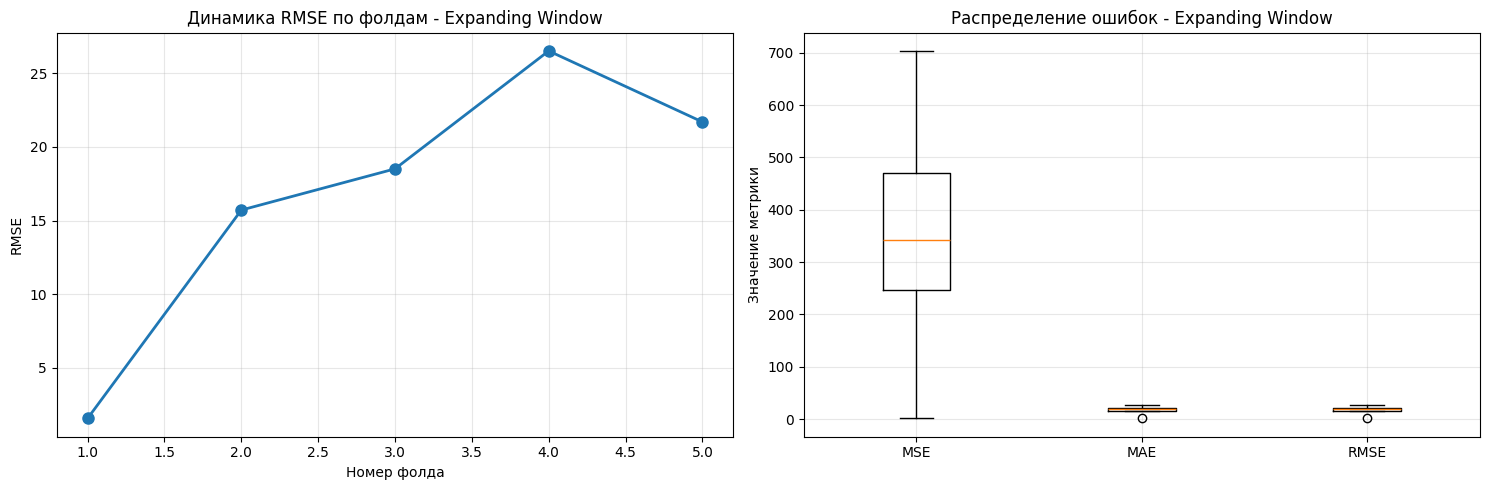


=== Sliding Window ===
Fold 1: Train size=365, Test size=1, RMSE=13.37
Fold 2: Train size=365, Test size=1, RMSE=21.69
Fold 3: Train size=365, Test size=1, RMSE=4.87
Fold 4: Train size=365, Test size=1, RMSE=1.81
Fold 5: Train size=365, Test size=1, RMSE=3.30
Средний RMSE: 9.01 (±7.50)
Средний MAE: 9.01
Количество фолдов: 5


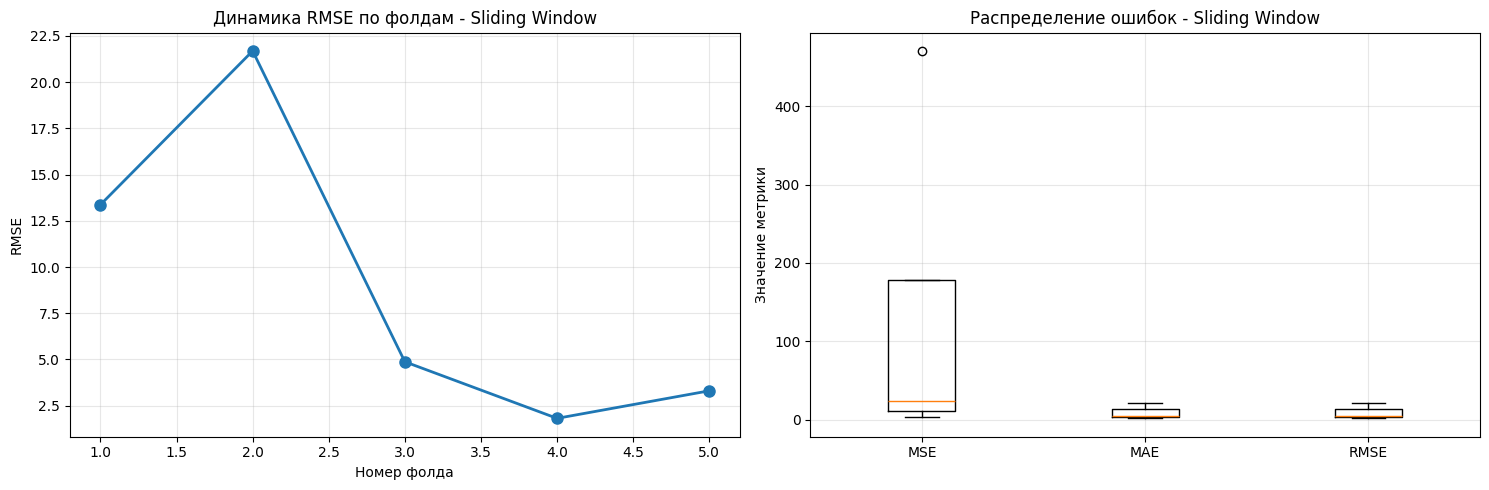


=== TimeSeriesSplit ===
Fold 1: Train size=365, Test size=1, RMSE=13.37
Fold 2: Train size=365, Test size=1, RMSE=21.69
Fold 3: Train size=365, Test size=1, RMSE=4.87
Fold 4: Train size=365, Test size=1, RMSE=1.81
Fold 5: Train size=365, Test size=1, RMSE=3.30
Средний RMSE: 9.01 (±7.50)
Средний MAE: 9.01
Количество фолдов: 5


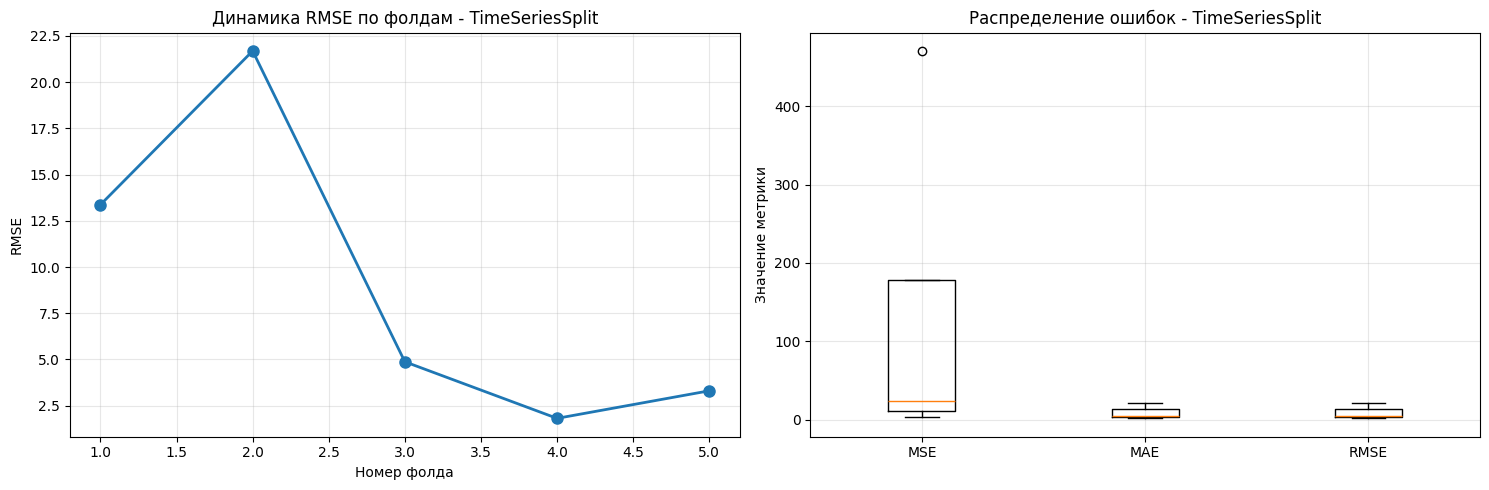


--- Модель: Random Forest ---

=== Expanding Window ===
Fold 1: Train size=100, Test size=1, RMSE=9.63
Fold 2: Train size=101, Test size=1, RMSE=5.35
Fold 3: Train size=102, Test size=1, RMSE=4.92
Fold 4: Train size=103, Test size=1, RMSE=12.21
Fold 5: Train size=104, Test size=1, RMSE=22.71
Средний RMSE: 10.96 (±6.47)
Средний MAE: 10.96
Количество фолдов: 5


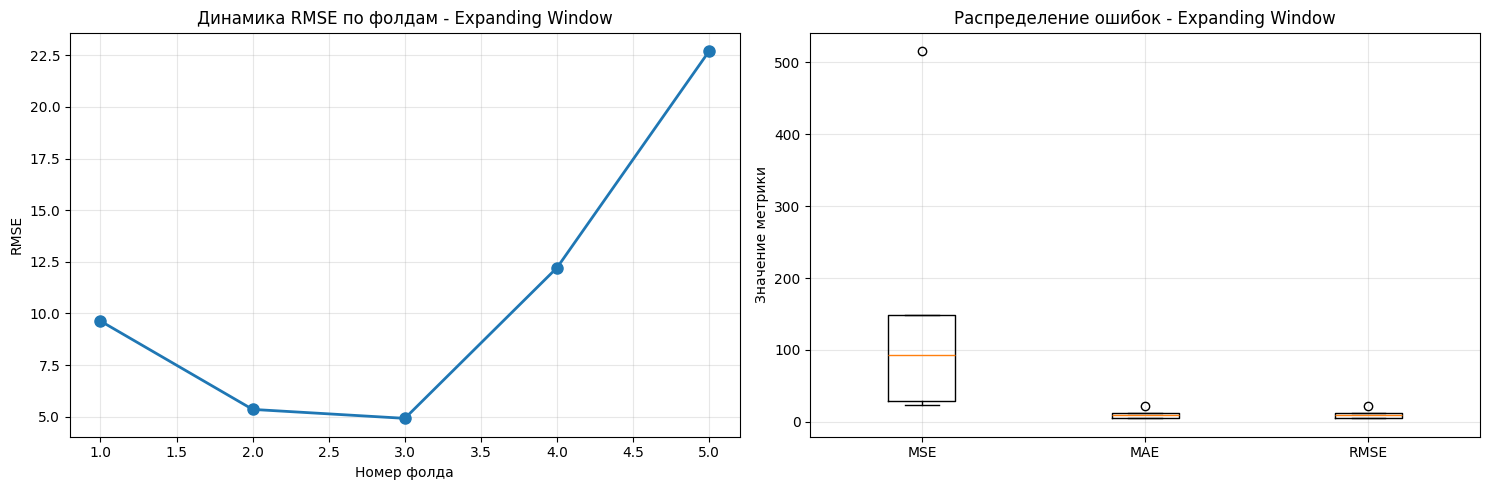


=== Sliding Window ===
Fold 1: Train size=365, Test size=1, RMSE=6.42
Fold 2: Train size=365, Test size=1, RMSE=19.98
Fold 3: Train size=365, Test size=1, RMSE=1.67
Fold 4: Train size=365, Test size=1, RMSE=7.30
Fold 5: Train size=365, Test size=1, RMSE=1.32
Средний RMSE: 7.34 (±6.77)
Средний MAE: 7.34
Количество фолдов: 5


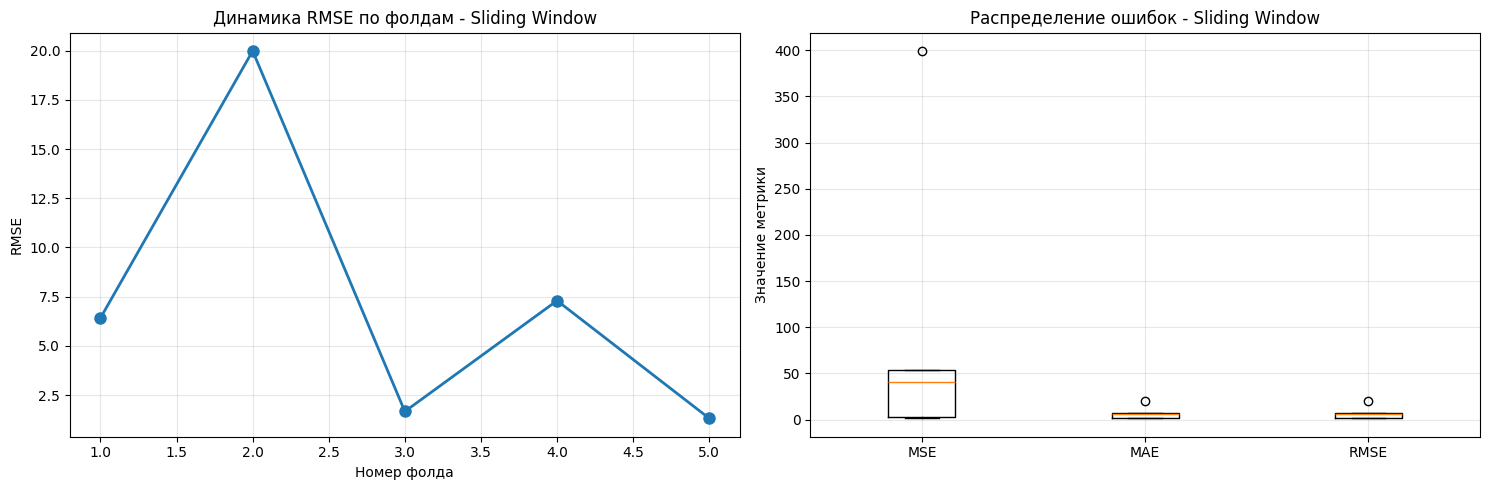


=== TimeSeriesSplit ===
Fold 1: Train size=365, Test size=1, RMSE=6.42
Fold 2: Train size=365, Test size=1, RMSE=19.98
Fold 3: Train size=365, Test size=1, RMSE=1.67
Fold 4: Train size=365, Test size=1, RMSE=7.30
Fold 5: Train size=365, Test size=1, RMSE=1.32
Средний RMSE: 7.34 (±6.77)
Средний MAE: 7.34
Количество фолдов: 5


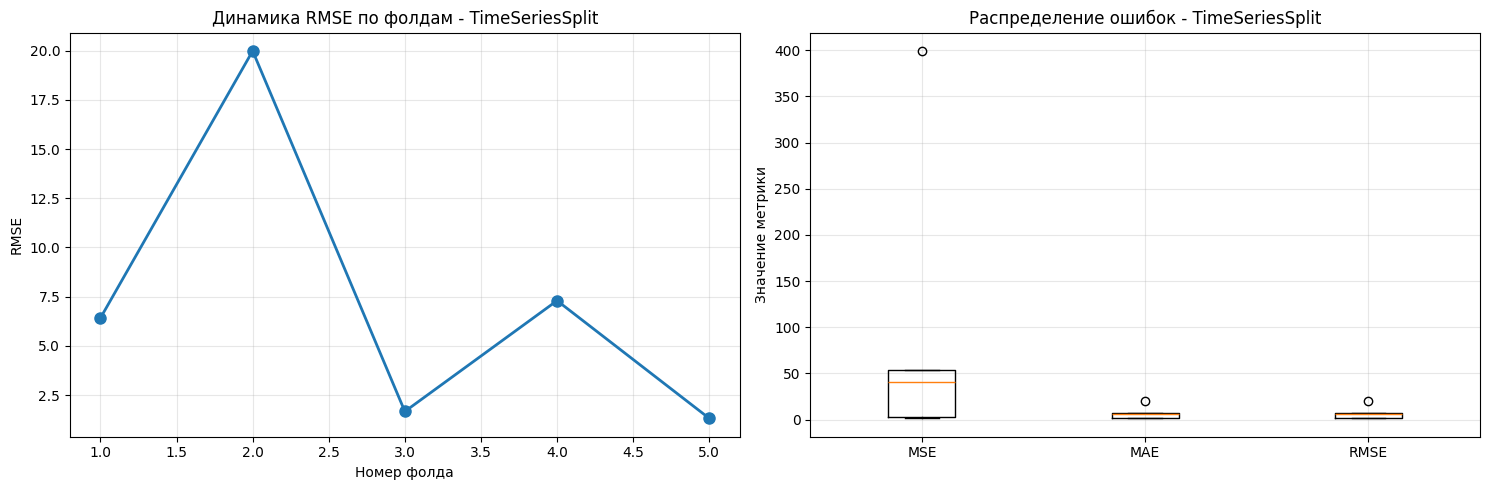


ГОРИЗОНТ ПРОГНОЗИРОВАНИЯ: 7 дней

--- Модель: Linear Regression ---

=== Expanding Window ===
Fold 1: Train size=100, Test size=7, RMSE=17.91
Fold 2: Train size=107, Test size=7, RMSE=18.52
Fold 3: Train size=114, Test size=7, RMSE=10.91
Fold 4: Train size=121, Test size=7, RMSE=13.53
Fold 5: Train size=128, Test size=7, RMSE=11.34
Средний RMSE: 14.44 (±3.21)
Средний MAE: 12.22
Количество фолдов: 5


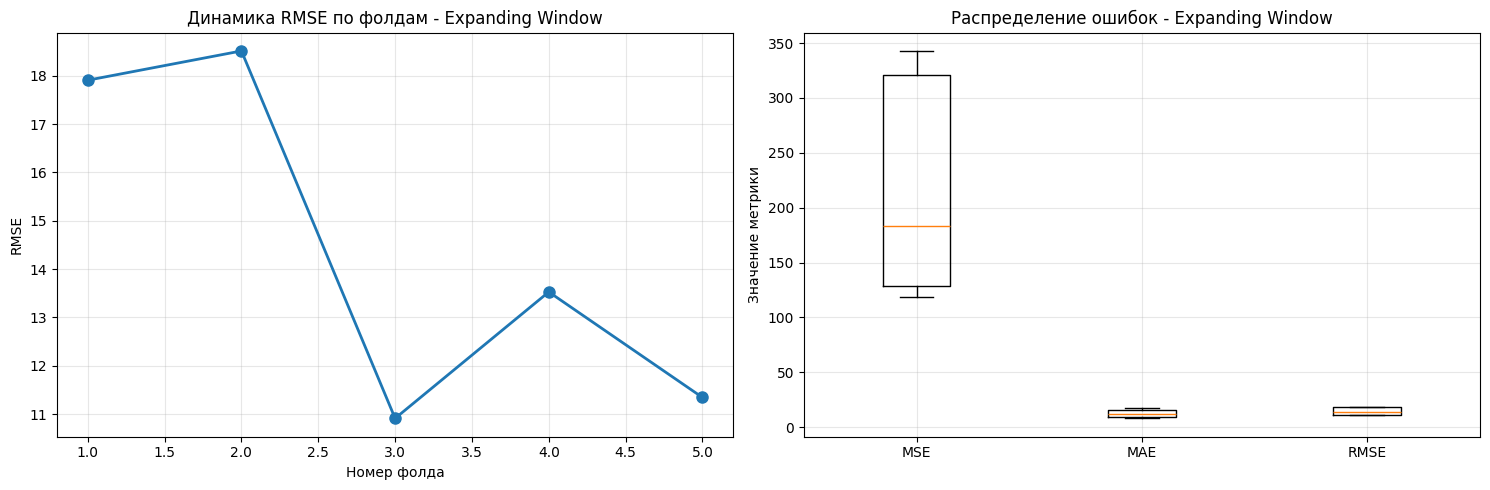


=== Sliding Window ===
Fold 1: Train size=365, Test size=7, RMSE=11.76
Fold 2: Train size=365, Test size=7, RMSE=14.19
Fold 3: Train size=365, Test size=7, RMSE=11.31
Fold 4: Train size=365, Test size=7, RMSE=10.91
Fold 5: Train size=365, Test size=7, RMSE=11.30
Средний RMSE: 11.89 (±1.18)
Средний MAE: 10.41
Количество фолдов: 5


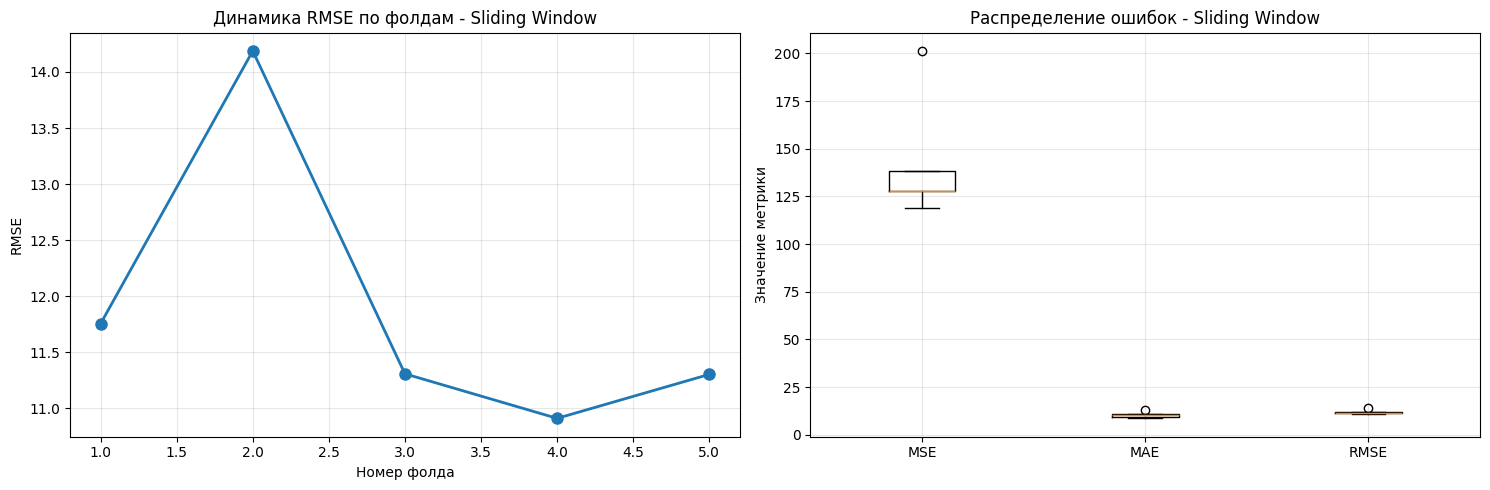


=== TimeSeriesSplit ===
Fold 1: Train size=365, Test size=7, RMSE=11.76
Fold 2: Train size=365, Test size=7, RMSE=14.19
Fold 3: Train size=365, Test size=7, RMSE=11.31
Fold 4: Train size=365, Test size=7, RMSE=10.91
Fold 5: Train size=365, Test size=7, RMSE=11.30
Средний RMSE: 11.89 (±1.18)
Средний MAE: 10.41
Количество фолдов: 5


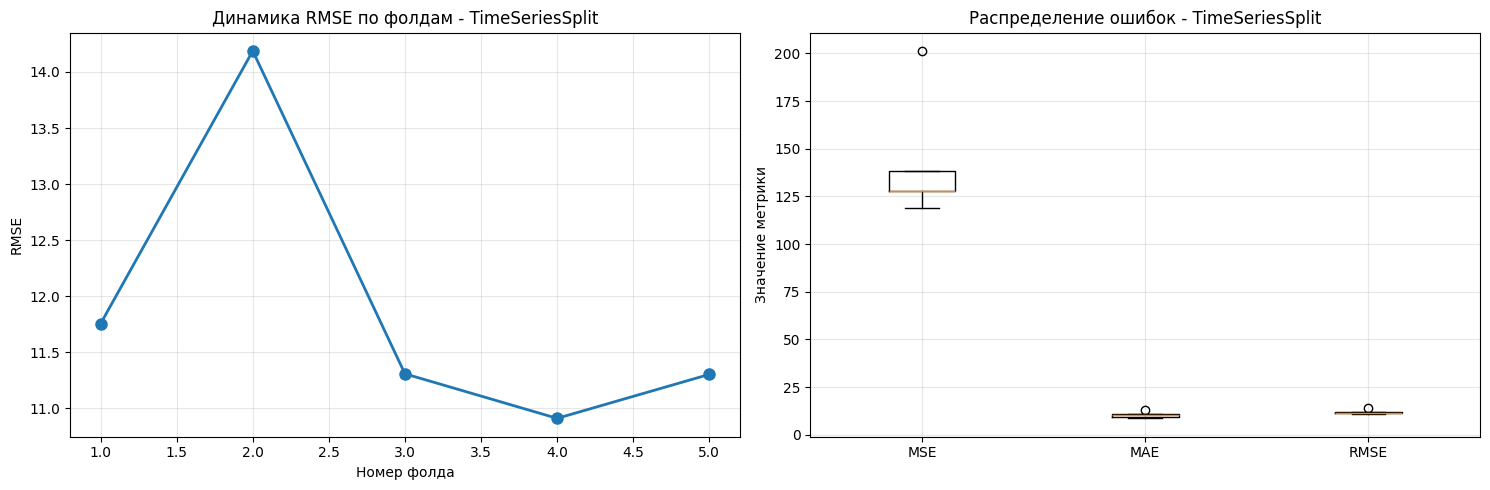


--- Модель: Random Forest ---

=== Expanding Window ===
Fold 1: Train size=100, Test size=7, RMSE=11.47
Fold 2: Train size=107, Test size=7, RMSE=7.91
Fold 3: Train size=114, Test size=7, RMSE=11.26
Fold 4: Train size=121, Test size=7, RMSE=12.50
Fold 5: Train size=128, Test size=7, RMSE=9.12
Средний RMSE: 10.45 (±1.68)
Средний MAE: 8.23
Количество фолдов: 5


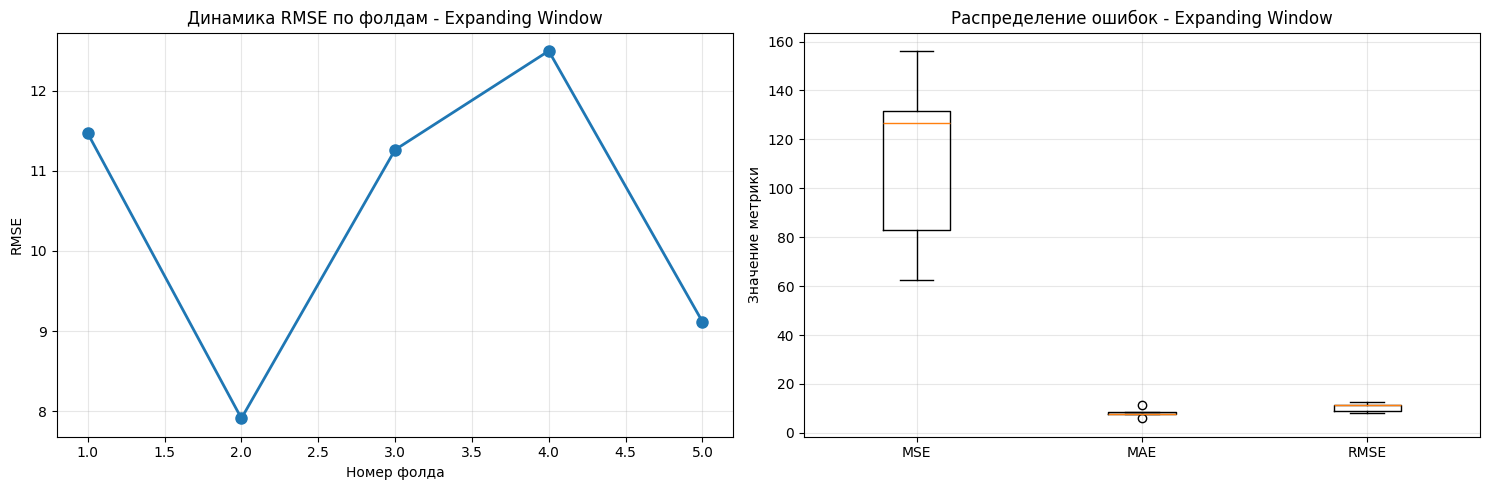


=== Sliding Window ===
Fold 1: Train size=365, Test size=7, RMSE=11.50
Fold 2: Train size=365, Test size=7, RMSE=15.90
Fold 3: Train size=365, Test size=7, RMSE=9.70
Fold 4: Train size=365, Test size=7, RMSE=9.66
Fold 5: Train size=365, Test size=7, RMSE=10.15
Средний RMSE: 11.38 (±2.36)
Средний MAE: 9.46
Количество фолдов: 5


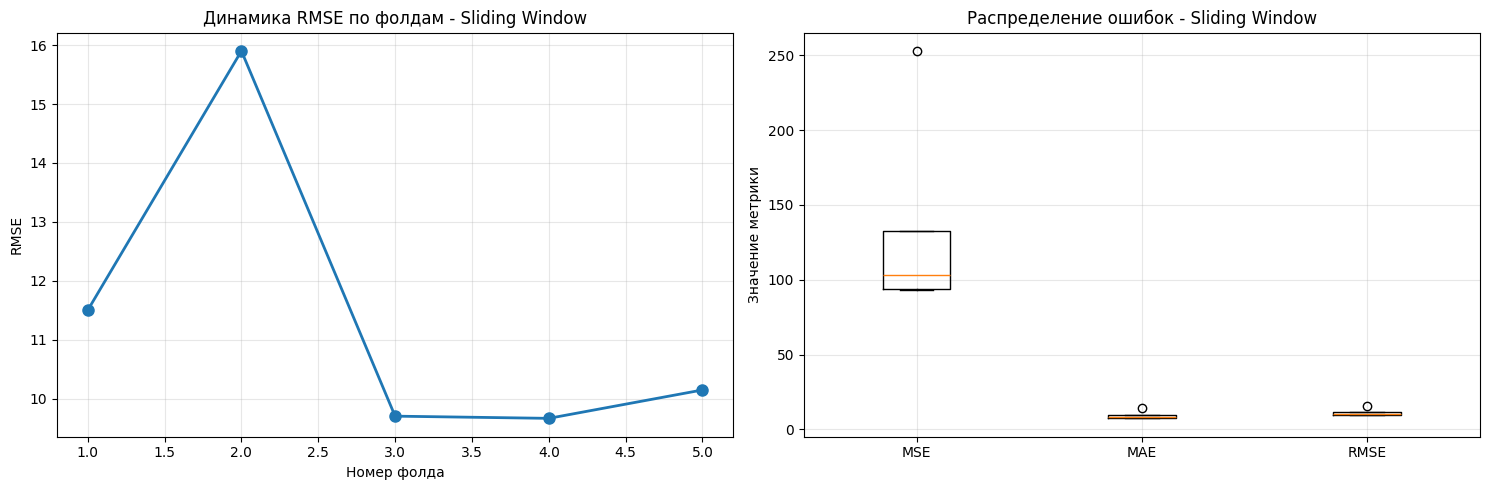


=== TimeSeriesSplit ===
Fold 1: Train size=365, Test size=7, RMSE=11.50
Fold 2: Train size=365, Test size=7, RMSE=15.90
Fold 3: Train size=365, Test size=7, RMSE=9.70
Fold 4: Train size=365, Test size=7, RMSE=9.66
Fold 5: Train size=365, Test size=7, RMSE=10.15
Средний RMSE: 11.38 (±2.36)
Средний MAE: 9.46
Количество фолдов: 5


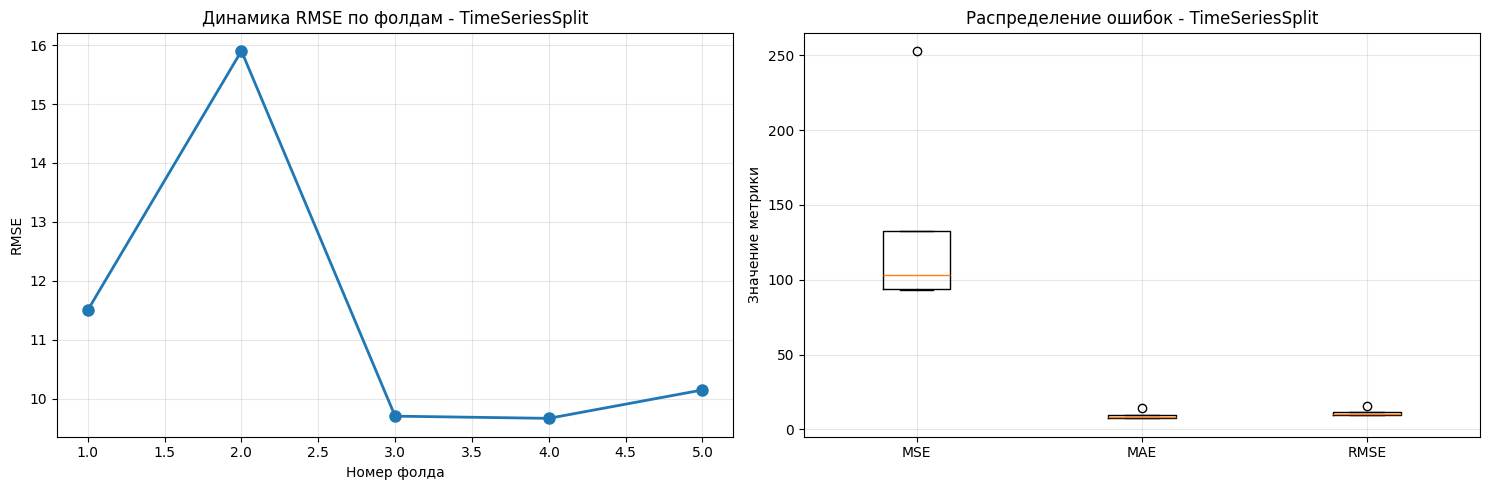


ГОРИЗОНТ ПРОГНОЗИРОВАНИЯ: 30 дней

--- Модель: Linear Regression ---

=== Expanding Window ===
Fold 1: Train size=100, Test size=30, RMSE=21.99
Fold 2: Train size=130, Test size=30, RMSE=17.92
Fold 3: Train size=160, Test size=30, RMSE=23.75
Fold 4: Train size=190, Test size=30, RMSE=19.70
Fold 5: Train size=220, Test size=30, RMSE=12.46
Средний RMSE: 19.16 (±3.89)
Средний MAE: 15.72
Количество фолдов: 5


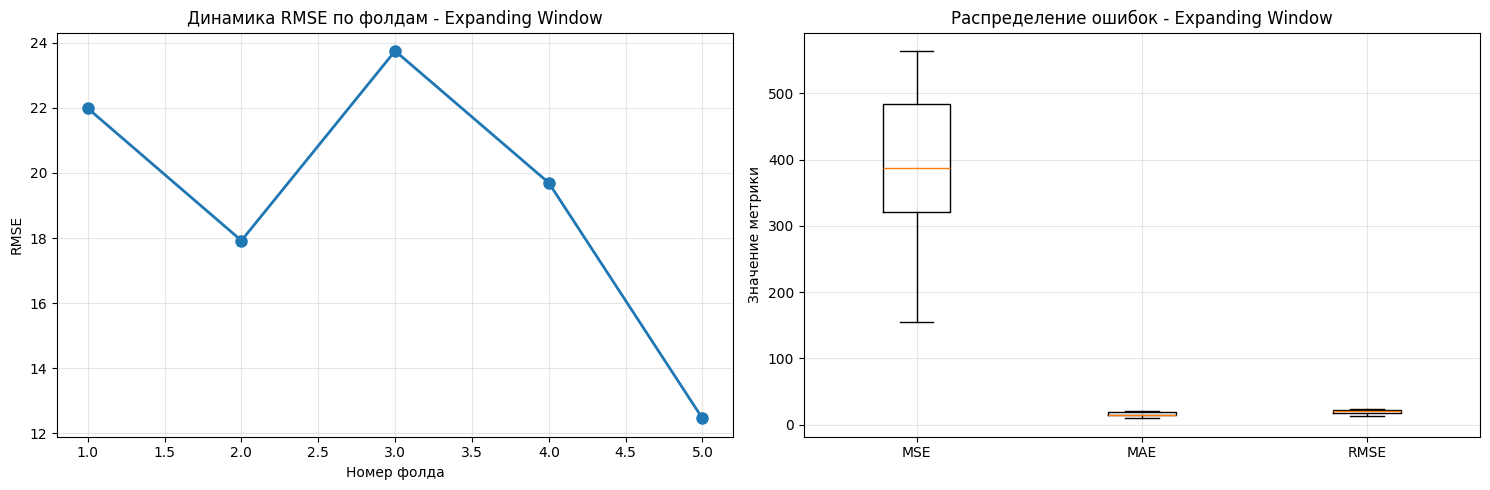


=== Sliding Window ===
Fold 1: Train size=365, Test size=30, RMSE=10.37
Fold 2: Train size=365, Test size=30, RMSE=12.75
Fold 3: Train size=365, Test size=30, RMSE=11.18
Fold 4: Train size=365, Test size=30, RMSE=12.25
Fold 5: Train size=365, Test size=30, RMSE=11.63
Средний RMSE: 11.64 (±0.83)
Средний MAE: 9.31
Количество фолдов: 5


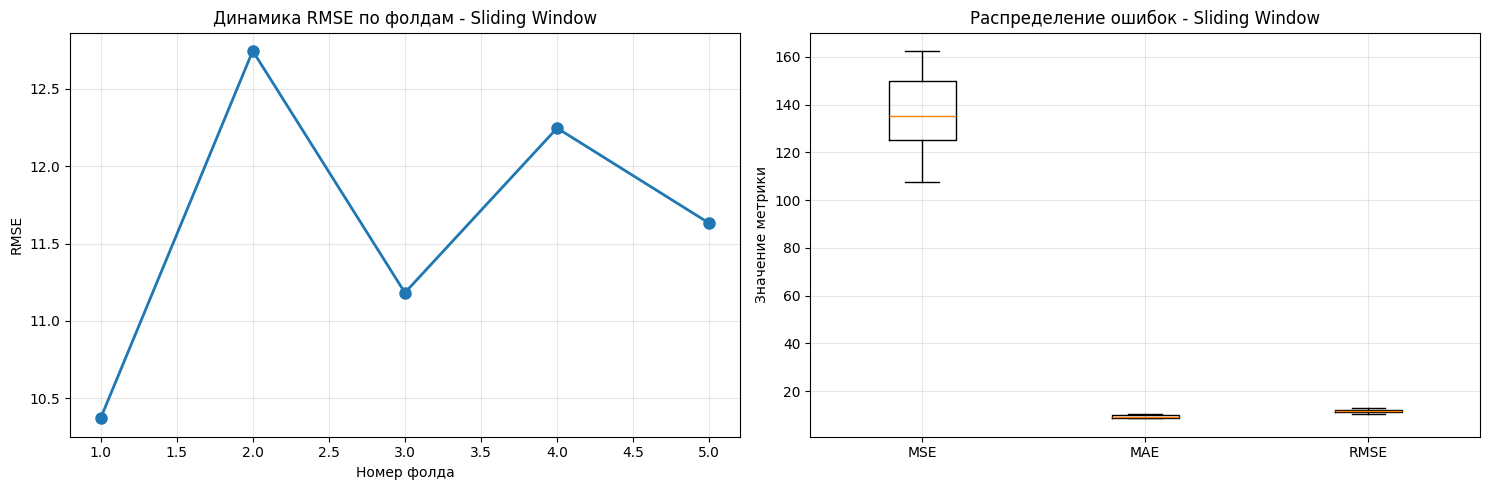


=== TimeSeriesSplit ===
Fold 1: Train size=365, Test size=30, RMSE=10.37
Fold 2: Train size=365, Test size=30, RMSE=12.75
Fold 3: Train size=365, Test size=30, RMSE=11.18
Fold 4: Train size=365, Test size=30, RMSE=12.25
Fold 5: Train size=365, Test size=30, RMSE=11.63
Средний RMSE: 11.64 (±0.83)
Средний MAE: 9.31
Количество фолдов: 5


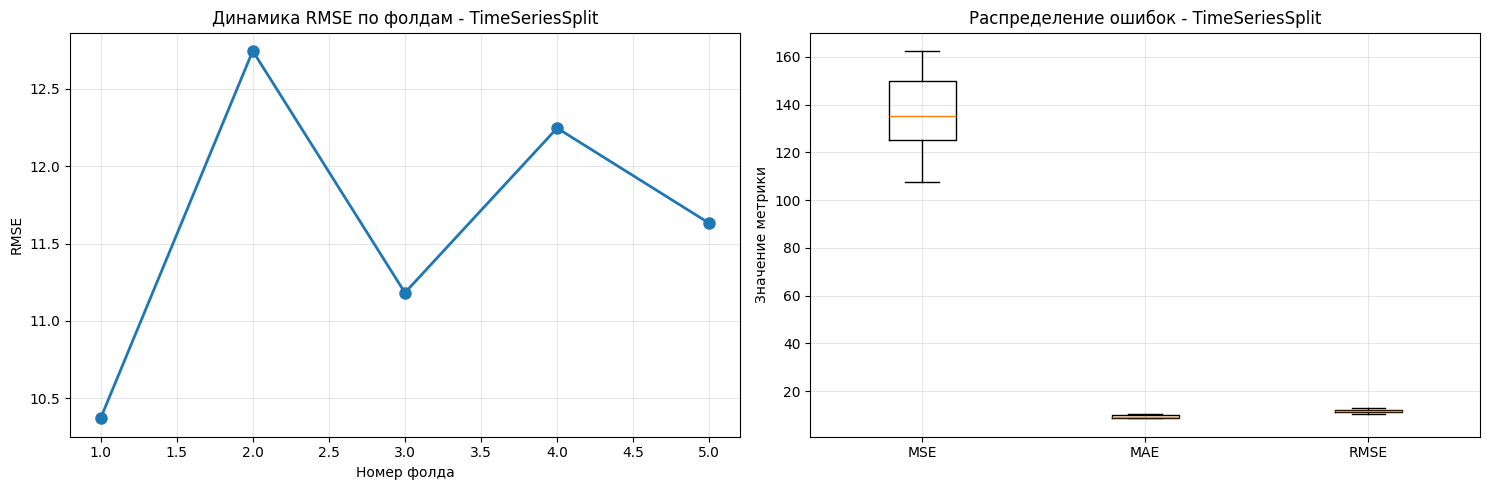


--- Модель: Random Forest ---

=== Expanding Window ===
Fold 1: Train size=100, Test size=30, RMSE=12.72
Fold 2: Train size=130, Test size=30, RMSE=24.88
Fold 3: Train size=160, Test size=30, RMSE=37.71
Fold 4: Train size=190, Test size=30, RMSE=17.30
Fold 5: Train size=220, Test size=30, RMSE=11.09
Средний RMSE: 20.74 (±9.74)
Средний MAE: 17.43
Количество фолдов: 5


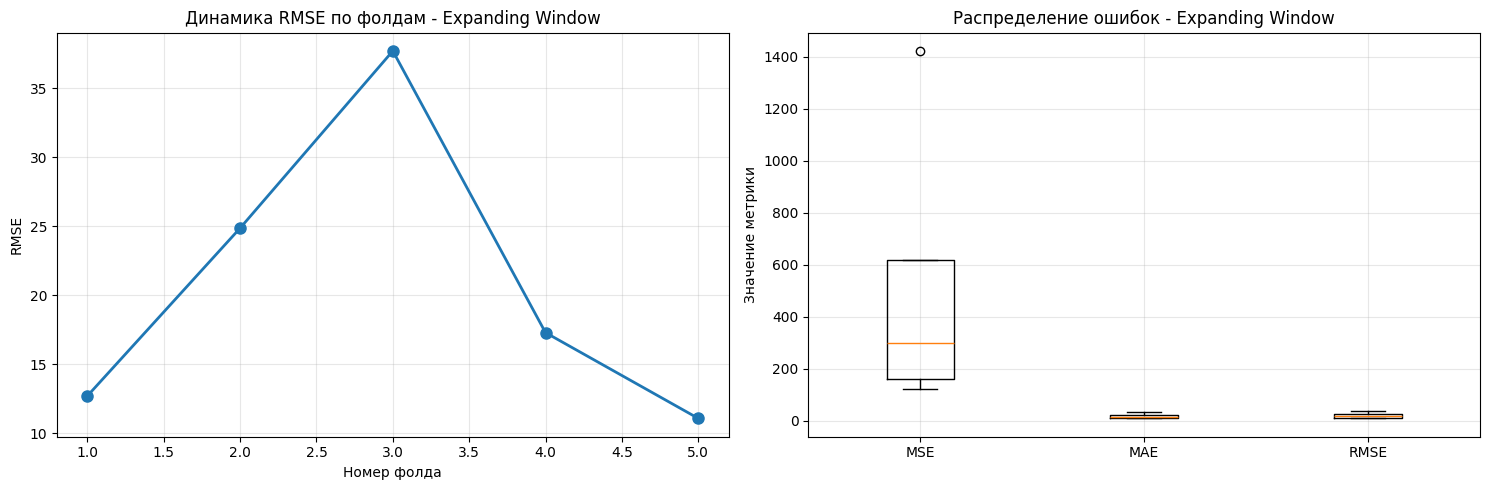


=== Sliding Window ===
Fold 1: Train size=365, Test size=30, RMSE=9.74
Fold 2: Train size=365, Test size=30, RMSE=16.82
Fold 3: Train size=365, Test size=30, RMSE=17.14
Fold 4: Train size=365, Test size=30, RMSE=13.38
Fold 5: Train size=365, Test size=30, RMSE=11.50
Средний RMSE: 13.72 (±2.90)
Средний MAE: 11.07
Количество фолдов: 5


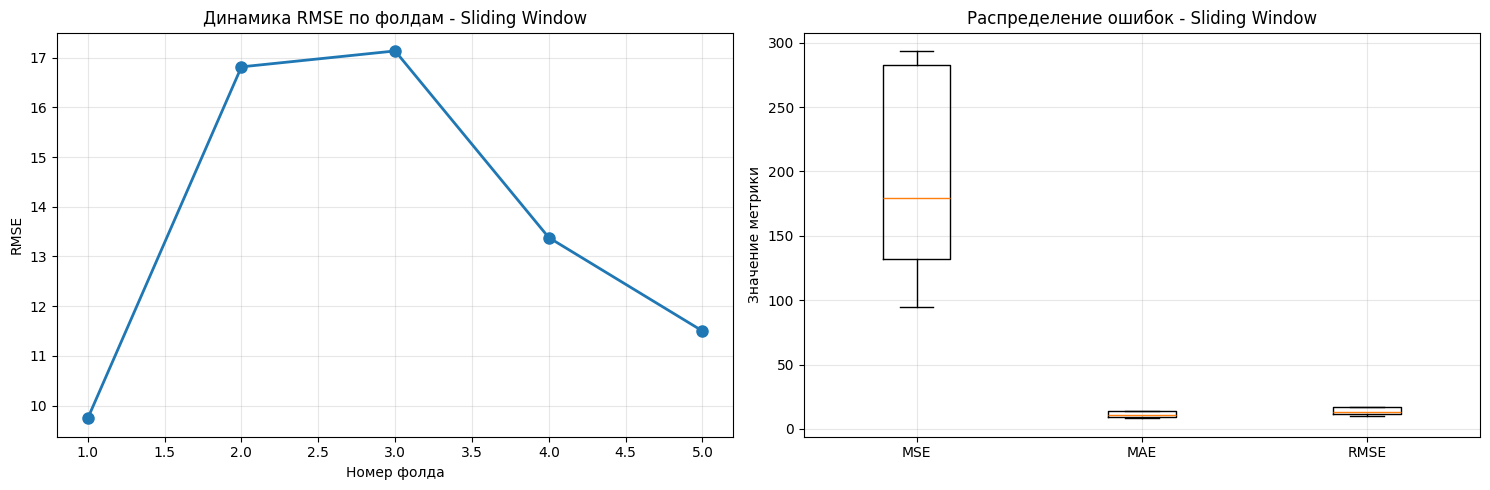


=== TimeSeriesSplit ===
Fold 1: Train size=365, Test size=30, RMSE=9.74
Fold 2: Train size=365, Test size=30, RMSE=16.82
Fold 3: Train size=365, Test size=30, RMSE=17.14
Fold 4: Train size=365, Test size=30, RMSE=13.38
Fold 5: Train size=365, Test size=30, RMSE=11.50
Средний RMSE: 13.72 (±2.90)
Средний MAE: 11.07
Количество фолдов: 5


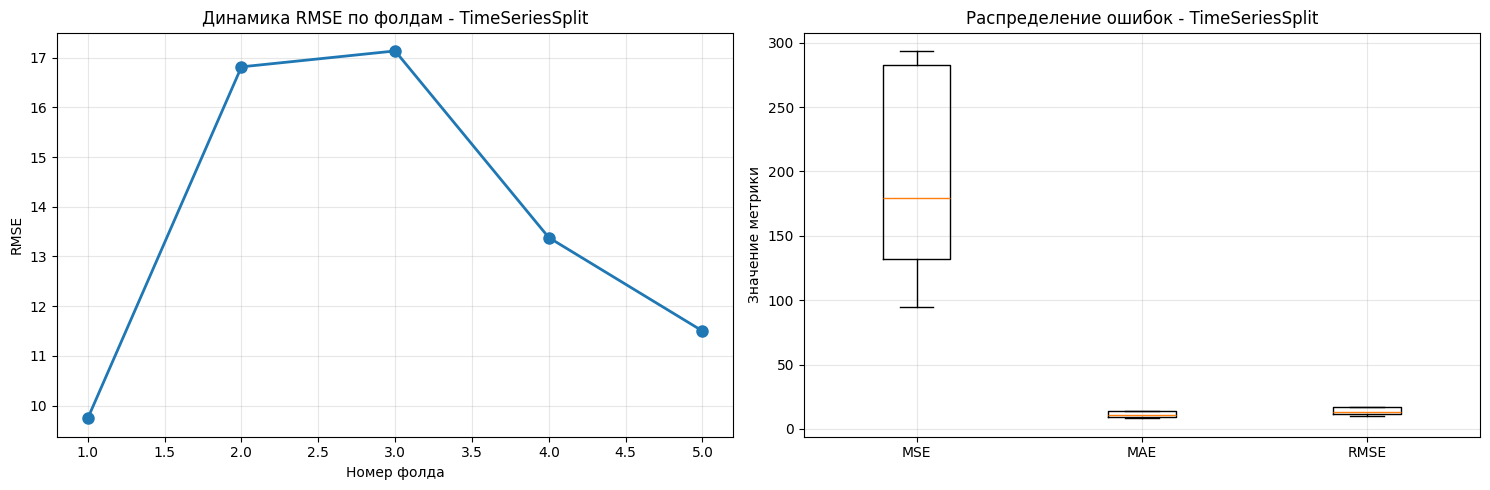


=== СВОДНЫЕ РЕЗУЛЬТАТЫ КРОСС-ВАЛИДАЦИИ ===

Горизонт 1:
--------------------------------------------------------------------------------
Модель               Метод CV             Ср. RMSE     Стд. RMSE    Фолдов  
--------------------------------------------------------------------------------
Linear Regression    Expanding Window     16.80        8.42         5       
Linear Regression    Sliding Window       9.01         7.50         5       
Linear Regression    TimeSeriesSplit      9.01         7.50         5       
Random Forest        Expanding Window     10.96        6.47         5       
Random Forest        Sliding Window       7.34         6.77         5       
Random Forest        TimeSeriesSplit      7.34         6.77         5       

Горизонт 7:
--------------------------------------------------------------------------------
Модель               Метод CV             Ср. RMSE     Стд. RMSE    Фолдов  
-----------------------------------------------------------------------

In [17]:
def create_lagged_features(series, max_lag=30):
    """Создание лаговых признаков из временного ряда"""
    X, y = [], []
    for i in range(max_lag, len(series)):
        X.append(series[i-max_lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

def expanding_window_cv(model, y, horizon=1, n_splits=5, min_train_size=100):
    """Кросс-валидация с расширяющимся окном"""
    cv_scores = {'mse': [], 'mae': [], 'rmse': []}
    fold_predictions = []
    fold_actuals = []
    
    train_size = min_train_size
    
    for i in range(n_splits):
        # Проверяем, что достаточно данных
        if train_size + horizon > len(y):
            break
            
        y_train = y.iloc[:train_size]
        y_test = y.iloc[train_size:train_size + horizon]
        
        # Создание лаговых признаков
        if len(y_train) < 31:  # нужно минимум 31 точка для 30 лагов
            train_size += horizon
            continue
            
        X_train, y_train_lag = create_lagged_features(y_train.values)
        
        # Проверяем, что есть данные для обучения
        if len(X_train) == 0:
            train_size += horizon
            continue
            
        # Обучение модели
        model_cv = model.__class__(**model.get_params())
        model_cv.fit(X_train, y_train_lag)
        
        # Прогнозирование
        predictions = []
        current_data = y_train.values[-30:]
        
        for h in range(horizon):
            pred = model_cv.predict(current_data.reshape(1, -1))[0]
            predictions.append(pred)
            current_data = np.append(current_data[1:], pred)
        
        predictions = np.array(predictions)
        
        # Сохранение результатов
        fold_predictions.append(predictions)
        fold_actuals.append(y_test.values)
        
        # Расчет метрик
        mse = mean_squared_error(y_test.values, predictions)
        mae = mean_absolute_error(y_test.values, predictions)
        rmse = np.sqrt(mse)
        
        cv_scores['mse'].append(mse)
        cv_scores['mae'].append(mae)
        cv_scores['rmse'].append(rmse)
        
        print(f"Fold {i+1}: Train size={len(y_train)}, Test size={len(y_test)}, RMSE={rmse:.2f}")
        
        train_size += horizon
    
    return cv_scores, fold_predictions, fold_actuals

def sliding_window_cv(model, y, horizon=1, window_size=365, n_splits=5):
    """Кросс-валидация со скользящим окном"""
    cv_scores = {'mse': [], 'mae': [], 'rmse': []}
    fold_predictions = []
    fold_actuals = []
    
    tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=window_size)
    fold_num = 0
    
    for train_index, test_index in tscv.split(y):
        # Проверяем размер тестового набора
        if len(test_index) < horizon:
            continue
            
        test_index = test_index[:horizon]
        
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        
        # Проверяем, что достаточно данных для лагов
        if len(y_train) < 31:
            continue
            
        # Создание лаговых признаков
        X_train, y_train_lag = create_lagged_features(y_train.values)
        
        if len(X_train) == 0:
            continue
            
        # Обучение модели
        model_cv = model.__class__(**model.get_params())
        model_cv.fit(X_train, y_train_lag)
        
        # Прогнозирование
        predictions = []
        current_data = y_train.values[-30:]
        
        for h in range(horizon):
            pred = model_cv.predict(current_data.reshape(1, -1))[0]
            predictions.append(pred)
            current_data = np.append(current_data[1:], pred)
        
        predictions = np.array(predictions)
        
        # Сохранение результатов
        fold_predictions.append(predictions)
        fold_actuals.append(y_test.values)
        
        # Расчет метрик
        mse = mean_squared_error(y_test.values, predictions)
        mae = mean_absolute_error(y_test.values, predictions)
        rmse = np.sqrt(mse)
        
        cv_scores['mse'].append(mse)
        cv_scores['mae'].append(mae)
        cv_scores['rmse'].append(rmse)
        
        fold_num += 1
        print(f"Fold {fold_num}: Train size={len(y_train)}, Test size={len(y_test)}, RMSE={rmse:.2f}")
    
    return cv_scores, fold_predictions, fold_actuals

def timeseries_split_cv(model, y, horizon=1, n_splits=5, max_train_size=365):
    """Кросс-валидация с использованием TimeSeriesSplit"""
    cv_scores = {'mse': [], 'mae': [], 'rmse': []}
    fold_predictions = []
    fold_actuals = []
    
    tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=max_train_size)
    fold_num = 0
    
    for train_index, test_index in tscv.split(y):
        if len(test_index) < horizon:
            continue
            
        test_index = test_index[:horizon]
        
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        
        # Проверяем, что достаточно данных для лагов
        if len(y_train) < 31:
            continue
            
        # Создание лаговых признаков
        X_train, y_train_lag = create_lagged_features(y_train.values)
        
        if len(X_train) == 0:
            continue
            
        # Обучение модели
        model_cv = model.__class__(**model.get_params())
        model_cv.fit(X_train, y_train_lag)
        
        # Прогнозирование
        predictions = []
        current_data = y_train.values[-30:]
        
        for h in range(horizon):
            pred = model_cv.predict(current_data.reshape(1, -1))[0]
            predictions.append(pred)
            current_data = np.append(current_data[1:], pred)
        
        predictions = np.array(predictions)
        
        # Сохранение результатов
        fold_predictions.append(predictions)
        fold_actuals.append(y_test.values)
        
        # Расчет метрик
        mse = mean_squared_error(y_test.values, predictions)
        mae = mean_absolute_error(y_test.values, predictions)
        rmse = np.sqrt(mse)
        
        cv_scores['mse'].append(mse)
        cv_scores['mae'].append(mae)
        cv_scores['rmse'].append(rmse)
        
        fold_num += 1
        print(f"Fold {fold_num}: Train size={len(y_train)}, Test size={len(y_test)}, RMSE={rmse:.2f}")
    
    return cv_scores, fold_predictions, fold_actuals

def plot_cv_results(cv_results, method_name):
    """Визуализация результатов кросс-валидации"""
    if not cv_results['rmse']:
        print(f"Нет данных для визуализации: {method_name}")
        return
        
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # График динамики ошибки по фолдам
    axes[0].plot(range(1, len(cv_results['rmse']) + 1), cv_results['rmse'], 
                marker='o', linewidth=2, markersize=8)
    axes[0].set_xlabel('Номер фолда')
    axes[0].set_ylabel('RMSE')
    axes[0].set_title(f'Динамика RMSE по фолдам - {method_name}')
    axes[0].grid(True, alpha=0.3)
    
    # Boxplot распределения ошибок
    metrics_data = [cv_results['mse'], cv_results['mae'], cv_results['rmse']]
    axes[1].boxplot(metrics_data, labels=['MSE', 'MAE', 'RMSE'])
    axes[1].set_ylabel('Значение метрики')
    axes[1].set_title(f'Распределение ошибок - {method_name}')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def compare_cv_methods(model, y, horizon=7, n_splits=5):
    """Сравнение методов кросс-валидации"""
    cv_methods = {
        'Expanding Window': expanding_window_cv,
        'Sliding Window': sliding_window_cv,
        'TimeSeriesSplit': timeseries_split_cv
    }
    
    results = {}
    
    for method_name, cv_function in cv_methods.items():
        print(f"\n=== {method_name} ===")
        
        if method_name == 'Expanding Window':
            cv_scores, preds, actuals = cv_function(model, y, horizon, n_splits, min_train_size=100)
        elif method_name == 'Sliding Window':
            cv_scores, preds, actuals = cv_function(model, y, horizon, 365, n_splits)
        else:  # TimeSeriesSplit
            cv_scores, preds, actuals = cv_function(model, y, horizon, n_splits, 365)
        
        results[method_name] = {
            'scores': cv_scores,
            'predictions': preds,
            'actuals': actuals
        }
        
        # Вывод средних метрик
        if cv_scores['rmse']:
            mean_rmse = np.mean(cv_scores['rmse'])
            std_rmse = np.std(cv_scores['rmse'])
            mean_mae = np.mean(cv_scores['mae'])
            
            print(f"Средний RMSE: {mean_rmse:.2f} (±{std_rmse:.2f})")
            print(f"Средний MAE: {mean_mae:.2f}")
            print(f"Количество фолдов: {len(cv_scores['rmse'])}")
        else:
            print("Нет валидных фолдов")
        
        # Визуализация
        plot_cv_results(cv_scores, method_name)
    
    return results

# Основной код выполнения
print("=== Кросс-валидация временных рядов ===\n")

# Используем данные из feature engineering
y_train_full = feature_engineering_results['y_train']

# Базовые модели
models_to_validate = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
}

# Предварительное обучение моделей
trained_models_cv = {}
for name, model in models_to_validate.items():
    # Создаем лаговые признаки для полного тренировочного набора
    if len(y_train_full) >= 31:
        X_lag_full, y_lag_full = create_lagged_features(y_train_full.values)
        model.fit(X_lag_full, y_lag_full)
        trained_models_cv[name] = model
        print(f"Модель {name} обучена на {len(X_lag_full)} примерах")
    else:
        print(f"Недостаточно данных для обучения {name}")

# Тестирование на разных горизонтах
horizons = [1, 7, 30]
cv_results_all = {}

for horizon in horizons:
    print(f"\n{'='*50}")
    print(f"ГОРИЗОНТ ПРОГНОЗИРОВАНИЯ: {horizon} дней")
    print(f"{'='*50}")
    
    cv_results_all[horizon] = {}
    
    for model_name, model in trained_models_cv.items():
        print(f"\n--- Модель: {model_name} ---")
        
        # Сравнение методов кросс-валидации
        results = compare_cv_methods(model, y_train_full, horizon=horizon, n_splits=5)
        cv_results_all[horizon][model_name] = results

# Сводная таблица результатов
print("\n=== СВОДНЫЕ РЕЗУЛЬТАТЫ КРОСС-ВАЛИДАЦИИ ===")

for horizon in horizons:
    print(f"\nГоризонт {horizon}:")
    print("-" * 80)
    print(f"{'Модель':<20} {'Метод CV':<20} {'Ср. RMSE':<12} {'Стд. RMSE':<12} {'Фолдов':<8}")
    print("-" * 80)
    
    for model_name in trained_models_cv.keys():
        if model_name in cv_results_all[horizon]:
            for cv_method in cv_results_all[horizon][model_name].keys():
                scores = cv_results_all[horizon][model_name][cv_method]['scores']
                if scores['rmse']:
                    mean_rmse = np.mean(scores['rmse'])
                    std_rmse = np.std(scores['rmse'])
                    n_folds = len(scores['rmse'])
                    print(f"{model_name:<20} {cv_method:<20} {mean_rmse:<12.2f} {std_rmse:<12.2f} {n_folds:<8}")
                else:
                    print(f"{model_name:<20} {cv_method:<20} {'-':<12} {'-':<12} {'0':<8}")

# Сохранение результатов
cv_final_results = {
    'cv_results': cv_results_all,
    'trained_models': trained_models_cv,
    'horizons': horizons
}

#### Модели

=== Построение моделей временных рядов ===

=== Базовые модели ARIMA ===
Fitting ARIMA...
Fitting SARIMA...
Fitting SARIMAX...
SARIMAX error: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

=== Модели волатильности ===
Fitting GARCH...

=== Сезонные модели ===
Fitting Prophet...
Prophet error: Found NaN in column 'lag_1'
Fitting TBATS...

=== Многомерные модели ===
Fitting VAR...
Forecast error for var: 'VARResults' object has no attribute 'y'

=== Бенчмарки ===
Naive forecast...
Seasonal Naive forecast...
Fitting SES...

=== Обратное преобразование ===

=== СВОДНЫЕ РЕЗУЛЬТАТЫ МОДЕЛЕЙ ===
Модель               RMSE         MAE          MSE         
ARIMA                12.79        10.34        163.46      
SARIMA               13.53        11.03        183.00      
GARCH                12.79        10.34        163.46      
TBATS                11.76        9.42         138.37      
Naive                12.86        10.40        165.40      
Seasonal

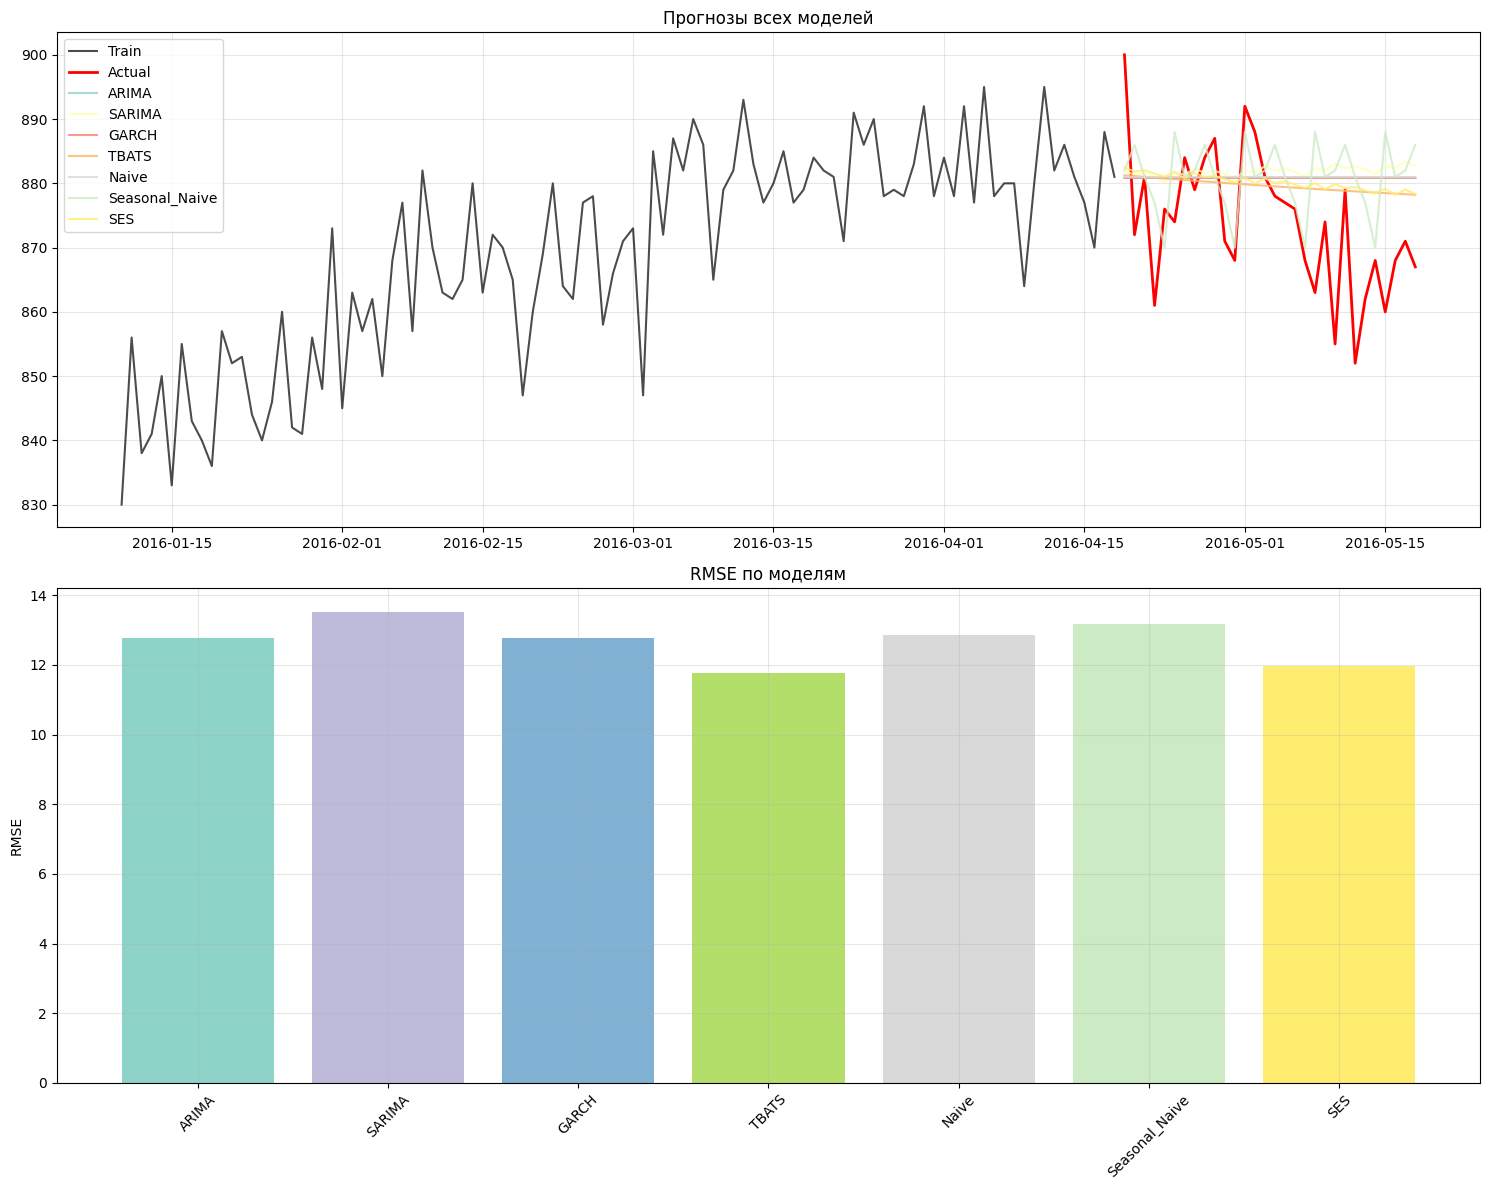


Лучшая модель: TBATS


In [20]:
def fit_arima(y, order=(1,1,1)):
    """ARIMA модель"""
    try:
        model = ARIMA(y, order=order)
        fitted_model = model.fit()
        return fitted_model
    except Exception as e:
        print(f"ARIMA error: {e}")
        return None

def fit_sarima(y, order=(1,1,1), seasonal_order=(1,1,1,12)):
    """SARIMA модель"""
    try:
        model = SARIMAX(y, order=order, seasonal_order=seasonal_order)
        fitted_model = model.fit(disp=False)
        return fitted_model
    except Exception as e:
        print(f"SARIMA error: {e}")
        return None

def fit_sarimax(y, exog, order=(1,1,1), seasonal_order=(1,1,1,12)):
    """SARIMAX модель с экзогенными переменными"""
    try:
        model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order)
        fitted_model = model.fit(disp=False)
        return fitted_model
    except Exception as e:
        print(f"SARIMAX error: {e}")
        return None

def fit_garch(arima_residuals, p=1, q=1):
    """GARCH модель на остатках ARIMA"""
    try:
        model = arch_model(arima_residuals, vol='Garch', p=p, q=q)
        fitted_model = model.fit(disp='off')
        return fitted_model
    except Exception as e:
        print(f"GARCH error: {e}")
        return None

def fit_prophet(df, changepoint_prior_scale=0.05, seasonality_prior_scale=10):
    """Prophet модель"""
    try:
        model = Prophet(
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale,
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True
        )
        
        # Добавляем дополнительные регрессоры если есть
        if df.shape[1] > 2:
            for col in df.columns[2:]:
                model.add_regressor(col)
        
        model.fit(df)
        return model
    except Exception as e:
        print(f"Prophet error: {e}")
        return None

def fit_tbats(y, seasonal_periods=[7, 365]):
    """TBATS модель для сложной сезонности"""
    try:
        estimator = TBATS(seasonal_periods=seasonal_periods, use_arma_errors=True)
        fitted_model = estimator.fit(y)
        return fitted_model
    except Exception as e:
        print(f"TBATS error: {e}")
        return None

def fit_var(data, maxlags=5):
    """VAR модель для многомерных рядов"""
    try:
        model = VAR(data)
        fitted_model = model.fit(maxlags=maxlags, ic='aic')
        return fitted_model
    except Exception as e:
        print(f"VAR error: {e}")
        return None

def fit_vecm(data, coint_rank=1):
    """VECM модель для коинтегрированных рядов"""
    try:
        model = VECM(data, k_ar_diff=1, coint_rank=coint_rank)
        fitted_model = model.fit()
        return fitted_model
    except Exception as e:
        print(f"VECM error: {e}")
        return None

def fit_ses(y, trend=None, seasonal=None, seasonal_periods=None):
    """Простое экспоненциальное сглаживание"""
    try:
        model = ExponentialSmoothing(
            y, 
            trend=trend, 
            seasonal=seasonal, 
            seasonal_periods=seasonal_periods
        )
        fitted_model = model.fit()
        return fitted_model
    except Exception as e:
        print(f"SES error: {e}")
        return None

def naive_forecast(y, horizon=1, seasonal_period=1):
    """Наивный прогноз"""
    if seasonal_period > 1:
        # Сезонный наивный
        return np.tile(y[-seasonal_period:], int(np.ceil(horizon/seasonal_period)))[:horizon]
    else:
        # Простой наивный
        return np.full(horizon, y[-1])

def inverse_boxcox(transformed_data, lambda_val):
    """Обратное преобразование Бокса-Кокса"""
    if lambda_val == 0:
        return np.exp(transformed_data)
    else:
        return np.exp(np.log(lambda_val * transformed_data + 1) / lambda_val)

def forecast_with_ci(model, model_type, horizon, exog=None, alpha=0.05):
    """Прогноз с доверительными интервалами"""
    try:
        if model_type == 'arima':
            forecast_result = model.get_forecast(steps=horizon)
            forecast = forecast_result.predicted_mean
            ci = forecast_result.conf_int(alpha=alpha)
            
        elif model_type == 'sarima':
            forecast_result = model.get_forecast(steps=horizon, exog=exog)
            forecast = forecast_result.predicted_mean
            ci = forecast_result.conf_int(alpha=alpha)
            
        elif model_type == 'prophet':
            future = model.make_future_dataframe(periods=horizon)
            if exog is not None:
                for col in exog.columns:
                    future[col] = exog[col].values
            forecast_result = model.predict(future)
            forecast = forecast_result['yhat'].values[-horizon:]
            ci_lower = forecast_result['yhat_lower'].values[-horizon:]
            ci_upper = forecast_result['yhat_upper'].values[-horizon:]
            ci = pd.DataFrame({'lower': ci_lower, 'upper': ci_upper})
            
        elif model_type == 'tbats':
            forecast_result = model.forecast(steps=horizon)
            forecast = forecast_result
            # TBATS не предоставляет CI по умолчанию
            ci = None
            
        elif model_type == 'var':
            forecast_result = model.forecast(model.y[-model.k_ar:], steps=horizon)
            forecast = forecast_result[:, 0]  # берем первый ряд
            ci = None
            
        elif model_type == 'ses':
            forecast_result = model.forecast(horizon)
            forecast = forecast_result
            ci = None
            
        else:
            forecast = model.forecast(steps=horizon)
            ci = None
            
        return forecast, ci
        
    except Exception as e:
        print(f"Forecast error for {model_type}: {e}")
        return None, None

def evaluate_model(forecast, actual, model_name):
    """Оценка модели"""
    if forecast is None or len(forecast) == 0:
        return None
        
    min_len = min(len(forecast), len(actual))
    forecast = forecast[:min_len]
    actual = actual[:min_len]
    
    mse = mean_squared_error(actual, forecast)
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mse)
    
    return {
        'model': model_name,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'forecast': forecast,
        'actual': actual
    }

# Основной код построения моделей
print("=== Построение моделей временных рядов ===\n")

# Подготовка данных
y_train = feature_engineering_results['y_train']
y_val = feature_engineering_results['y_val']
X_train = feature_engineering_results['X_train']
X_val = feature_engineering_results['X_val']

# Данные для Prophet
prophet_train = feature_engineering_results['prophet_train']
prophet_val = feature_engineering_results['prophet_val']

# Горизонт прогнозирования
horizon = 30

models_results = {}

# 1. Базовые модели ARIMA
print("=== Базовые модели ARIMA ===")

# ARIMA
print("Fitting ARIMA...")
arima_model = fit_arima(y_train, order=(1,1,1))
if arima_model:
    arima_forecast, arima_ci = forecast_with_ci(arima_model, 'arima', horizon)
    models_results['ARIMA'] = evaluate_model(arima_forecast, y_val[:horizon], 'ARIMA')

# SARIMA
print("Fitting SARIMA...")
sarima_model = fit_sarima(y_train, order=(1,1,1), seasonal_order=(1,1,1,7))
if sarima_model:
    sarima_forecast, sarima_ci = forecast_with_ci(sarima_model, 'sarima', horizon)
    models_results['SARIMA'] = evaluate_model(sarima_forecast, y_val[:horizon], 'SARIMA')

# SARIMAX
print("Fitting SARIMAX...")
if len(X_train) > 0:
    sarimax_model = fit_sarimax(y_train, X_train, order=(1,1,1), seasonal_order=(1,1,1,7))
    if sarimax_model:
        sarimax_forecast, sarimax_ci = forecast_with_ci(sarimax_model, 'sarima', horizon, exog=X_val[:horizon])
        models_results['SARIMAX'] = evaluate_model(sarimax_forecast, y_val[:horizon], 'SARIMAX')

# 2. Модели волатильности
print("\n=== Модели волатильности ===")

if arima_model:
    # GARCH на остатках ARIMA
    print("Fitting GARCH...")
    residuals = arima_model.resid.dropna()
    garch_model = fit_garch(residuals)
    if garch_model:
        garch_forecast = garch_model.forecast(horizon=horizon)
        # Для простоты используем ARIMA прогноз + GARCH волатильность
        combined_forecast = arima_forecast if arima_forecast is not None else None
        models_results['GARCH'] = evaluate_model(combined_forecast, y_val[:horizon], 'GARCH')

# 3. Сезонные модели
print("\n=== Сезонные модели ===")

# Prophet
print("Fitting Prophet...")
prophet_model = fit_prophet(prophet_train)
if prophet_model:
    prophet_forecast, prophet_ci = forecast_with_ci(prophet_model, 'prophet', horizon)
    models_results['Prophet'] = evaluate_model(prophet_forecast, y_val[:horizon], 'Prophet')

# TBATS
print("Fitting TBATS...")
tbats_model = fit_tbats(y_train.values, seasonal_periods=[7])
if tbats_model:
    tbats_forecast, tbats_ci = forecast_with_ci(tbats_model, 'tbats', horizon)
    models_results['TBATS'] = evaluate_model(tbats_forecast, y_val[:horizon], 'TBATS')

# 4. Многомерные модели (если есть дополнительные ряды)
print("\n=== Многомерные модели ===")

# Для VAR/VECM нужны минимум 2 ряда
# Создаем искусственный второй ряд (например, лаги)
if len(X_train) > 1:
    var_data = pd.DataFrame({
        'y': y_train.values[:len(X_train)],
        'exog1': X_train.iloc[:len(y_train), 0].values if len(X_train) > 0 else np.zeros(len(y_train))
    })
    
    print("Fitting VAR...")
    var_model = fit_var(var_data)
    if var_model:
        var_forecast, var_ci = forecast_with_ci(var_model, 'var', horizon)
        models_results['VAR'] = evaluate_model(var_forecast, y_val[:horizon], 'VAR')

# 5. Бенчмарки
print("\n=== Бенчмарки ===")

# Naive
print("Naive forecast...")
naive_forecast_vals = naive_forecast(y_train.values, horizon=horizon)
models_results['Naive'] = evaluate_model(naive_forecast_vals, y_val[:horizon], 'Naive')

# Seasonal Naive
print("Seasonal Naive forecast...")
seasonal_naive_forecast = naive_forecast(y_train.values, horizon=horizon, seasonal_period=7)
models_results['Seasonal_Naive'] = evaluate_model(seasonal_naive_forecast, y_val[:horizon], 'Seasonal_Naive')

# SES
print("Fitting SES...")
ses_model = fit_ses(y_train, trend='add', seasonal='add', seasonal_periods=7)
if ses_model:
    ses_forecast, ses_ci = forecast_with_ci(ses_model, 'ses', horizon)
    models_results['SES'] = evaluate_model(ses_forecast, y_val[:horizon], 'SES')

# 6. Обратное преобразование если применялось Box-Cox
print("\n=== Обратное преобразование ===")
# Здесь можно добавить обратное преобразование если данные трансформировались

# Сводные результаты
print("\n=== СВОДНЫЕ РЕЗУЛЬТАТЫ МОДЕЛЕЙ ===")
print("=" * 80)
print(f"{'Модель':<20} {'RMSE':<12} {'MAE':<12} {'MSE':<12}")
print("=" * 80)

results_summary = []
for model_name, result in models_results.items():
    if result is not None:
        results_summary.append({
            'model': model_name,
            'rmse': result['rmse'],
            'mae': result['mae'],
            'mse': result['mse']
        })
        print(f"{model_name:<20} {result['rmse']:<12.2f} {result['mae']:<12.2f} {result['mse']:<12.2f}")

# Сортировка по RMSE
results_summary.sort(key=lambda x: x['rmse'] if x['rmse'] is not None else float('inf'))

print("\n=== РЕЙТИНГ МОДЕЛЕЙ (по RMSE) ===")
print("=" * 50)
print(f"{'Место':<6} {'Модель':<20} {'RMSE':<12}")
print("=" * 50)
for i, result in enumerate(results_summary, 1):
    print(f"{i:<6} {result['model']:<20} {result['rmse']:<12.2f}")

# Визуализация прогнозов
def plot_forecasts(models_results, y_train, y_val, horizon):
    """Визуализация прогнозов всех моделей"""
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
    # График 1: Все прогнозы
    axes[0].plot(y_train.index[-100:], y_train.values[-100:], label='Train', color='black', alpha=0.7)
    axes[0].plot(y_val.index[:horizon], y_val.values[:horizon], label='Actual', color='red', linewidth=2)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(models_results)))
    for (model_name, result), color in zip(models_results.items(), colors):
        if result is not None and result['forecast'] is not None:
            axes[0].plot(y_val.index[:horizon], result['forecast'], 
                       label=model_name, color=color, alpha=0.8)
    
    axes[0].set_title('Прогнозы всех моделей')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # График 2: Ошибки по моделям
    rmse_values = []
    model_names = []
    for model_name, result in models_results.items():
        if result is not None and result['rmse'] is not None:
            rmse_values.append(result['rmse'])
            model_names.append(model_name)
    
    axes[1].bar(model_names, rmse_values, color=plt.cm.Set3(np.linspace(0, 1, len(model_names))))
    axes[1].set_title('RMSE по моделям')
    axes[1].set_ylabel('RMSE')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Визуализация результатов
plot_forecasts(models_results, y_train, y_val, horizon)

# Сохранение результатов
modeling_results = {
    'models': models_results,
    'results_summary': results_summary,
    'best_model': results_summary[0]['model'] if results_summary else None
}

print(f"\nЛучшая модель: {modeling_results['best_model']}")

#### Диагностика моделей

=== ДИАГНОСТИКА МОДЕЛЕЙ ===

Топ-3 модели для диагностики:
1. TBATS: RMSE = 11.76
2. SES: RMSE = 11.98
3. ARIMA: RMSE = 12.79

ГОРИЗОНТ ПРОГНОЗИРОВАНИЯ: 7

--- Модель: TBATS ---

ДИАГНОСТИКА МОДЕЛИ: TBATS (h=7)
Статистика остатков:
  Количество точек: 7
  Среднее: -2.5962
  Стандартное отклонение: 11.0937
  Минимум: -19.8784
  Максимум: 18.7463

1. Тест Льюнга-Бокса:
   p-value: 0.1133
   Остатки - белый шум: ДА
Shapiro-Wilk test error: name 'stats' is not defined

2. Тесты на нормальность:
   Харке-Бера: p-value = 0.8777
   Асимметрия: 0.4653, Эксцесс: 2.8315

3. Тест Бройша-Пагана:
   p-value: 0.1940
   Гомоскедастичность: ДА


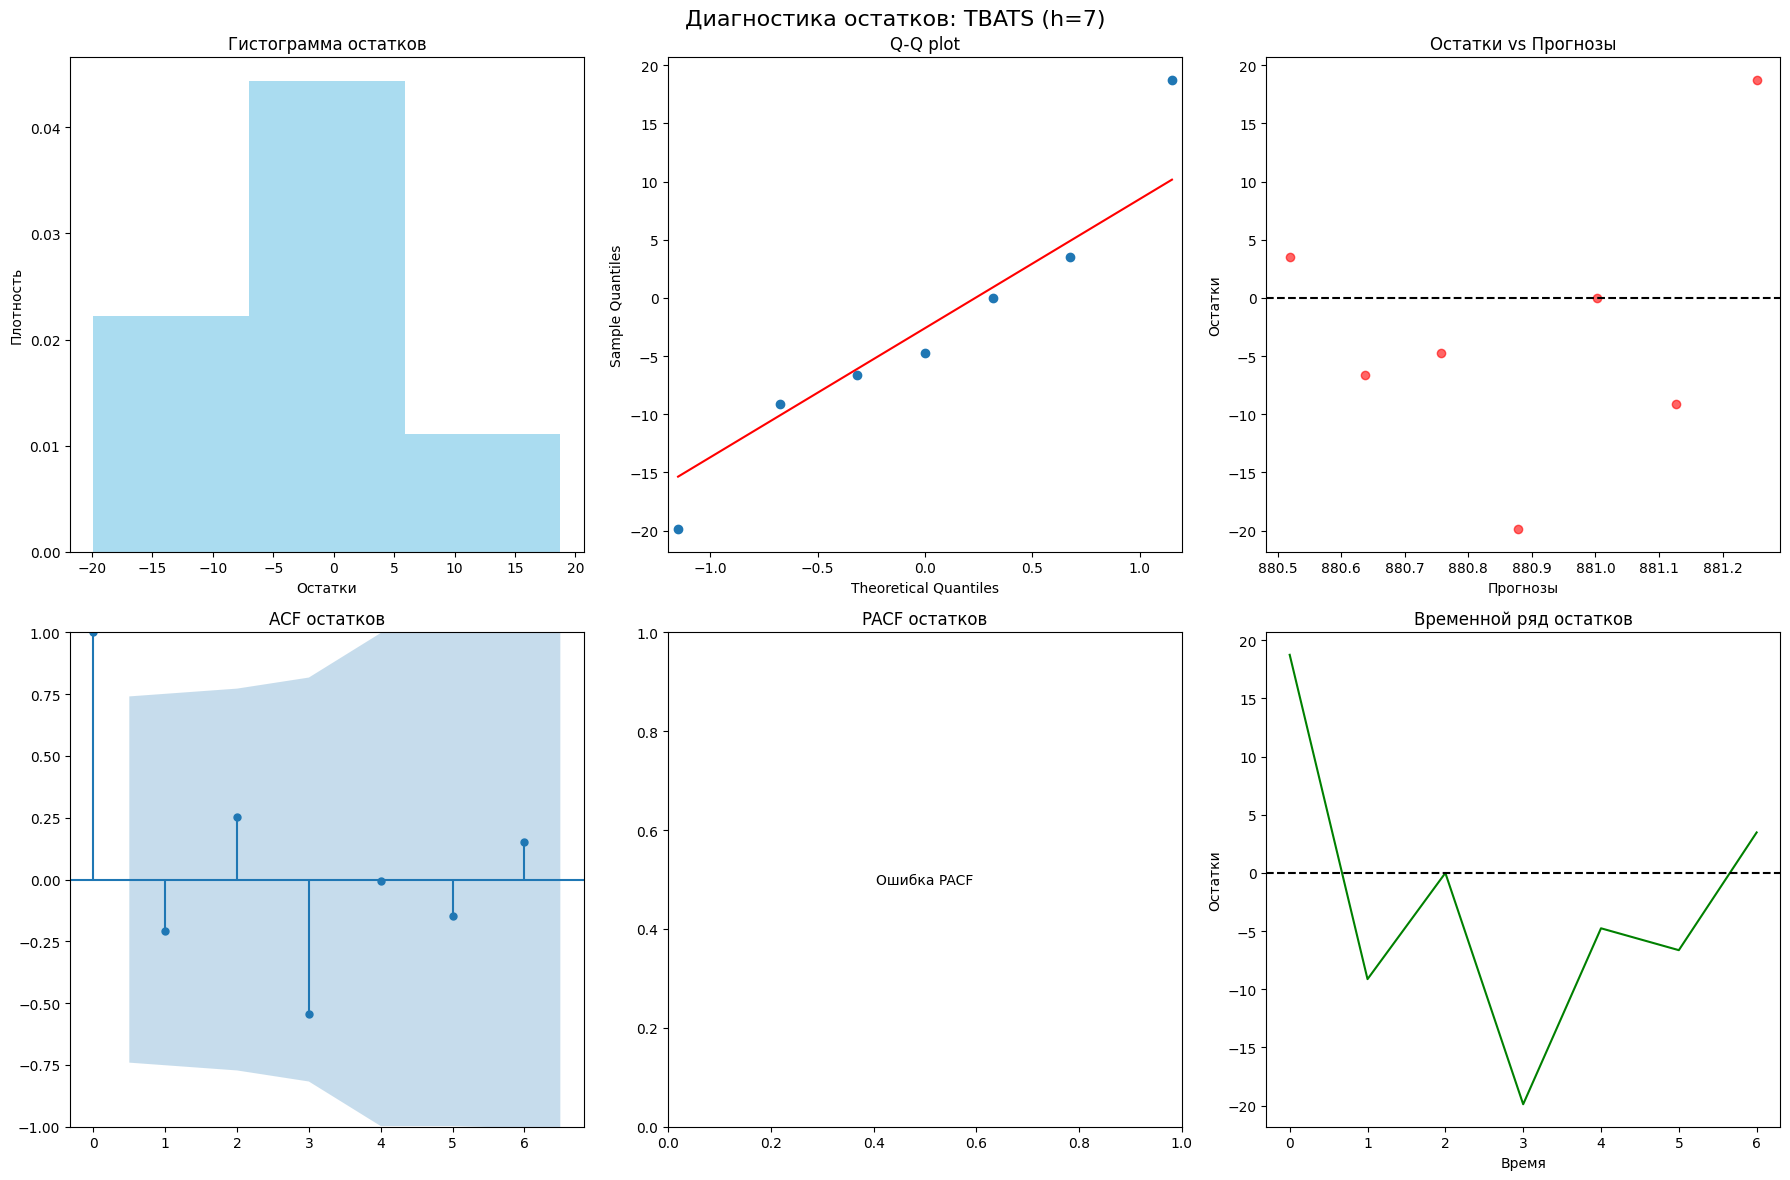

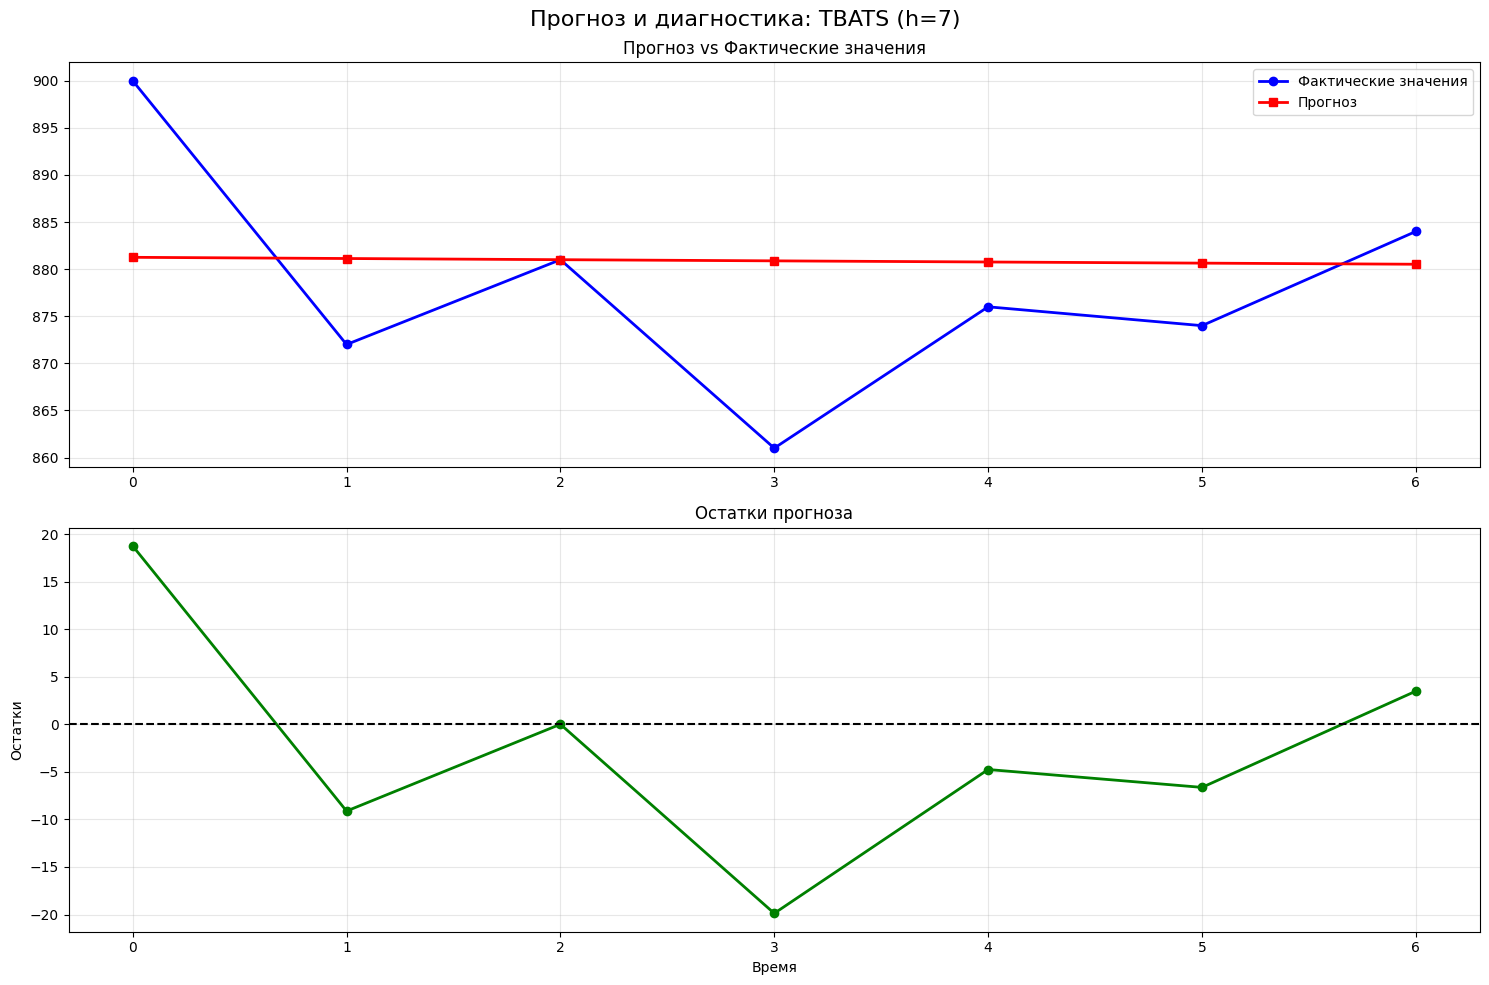


--- Модель: SES ---

ДИАГНОСТИКА МОДЕЛИ: SES (h=7)
Статистика остатков:
  Количество точек: 7
  Среднее: -3.3572
  Стандартное отклонение: 10.9626
  Минимум: -20.4984
  Максимум: 17.5061

1. Тест Льюнга-Бокса:
   p-value: 0.1003
   Остатки - белый шум: ДА
Shapiro-Wilk test error: name 'stats' is not defined

2. Тесты на нормальность:
   Харке-Бера: p-value = 0.8903
   Асимметрия: 0.4310, Эксцесс: 2.7674

3. Тест Бройша-Пагана:
   p-value: 0.3457
   Гомоскедастичность: ДА


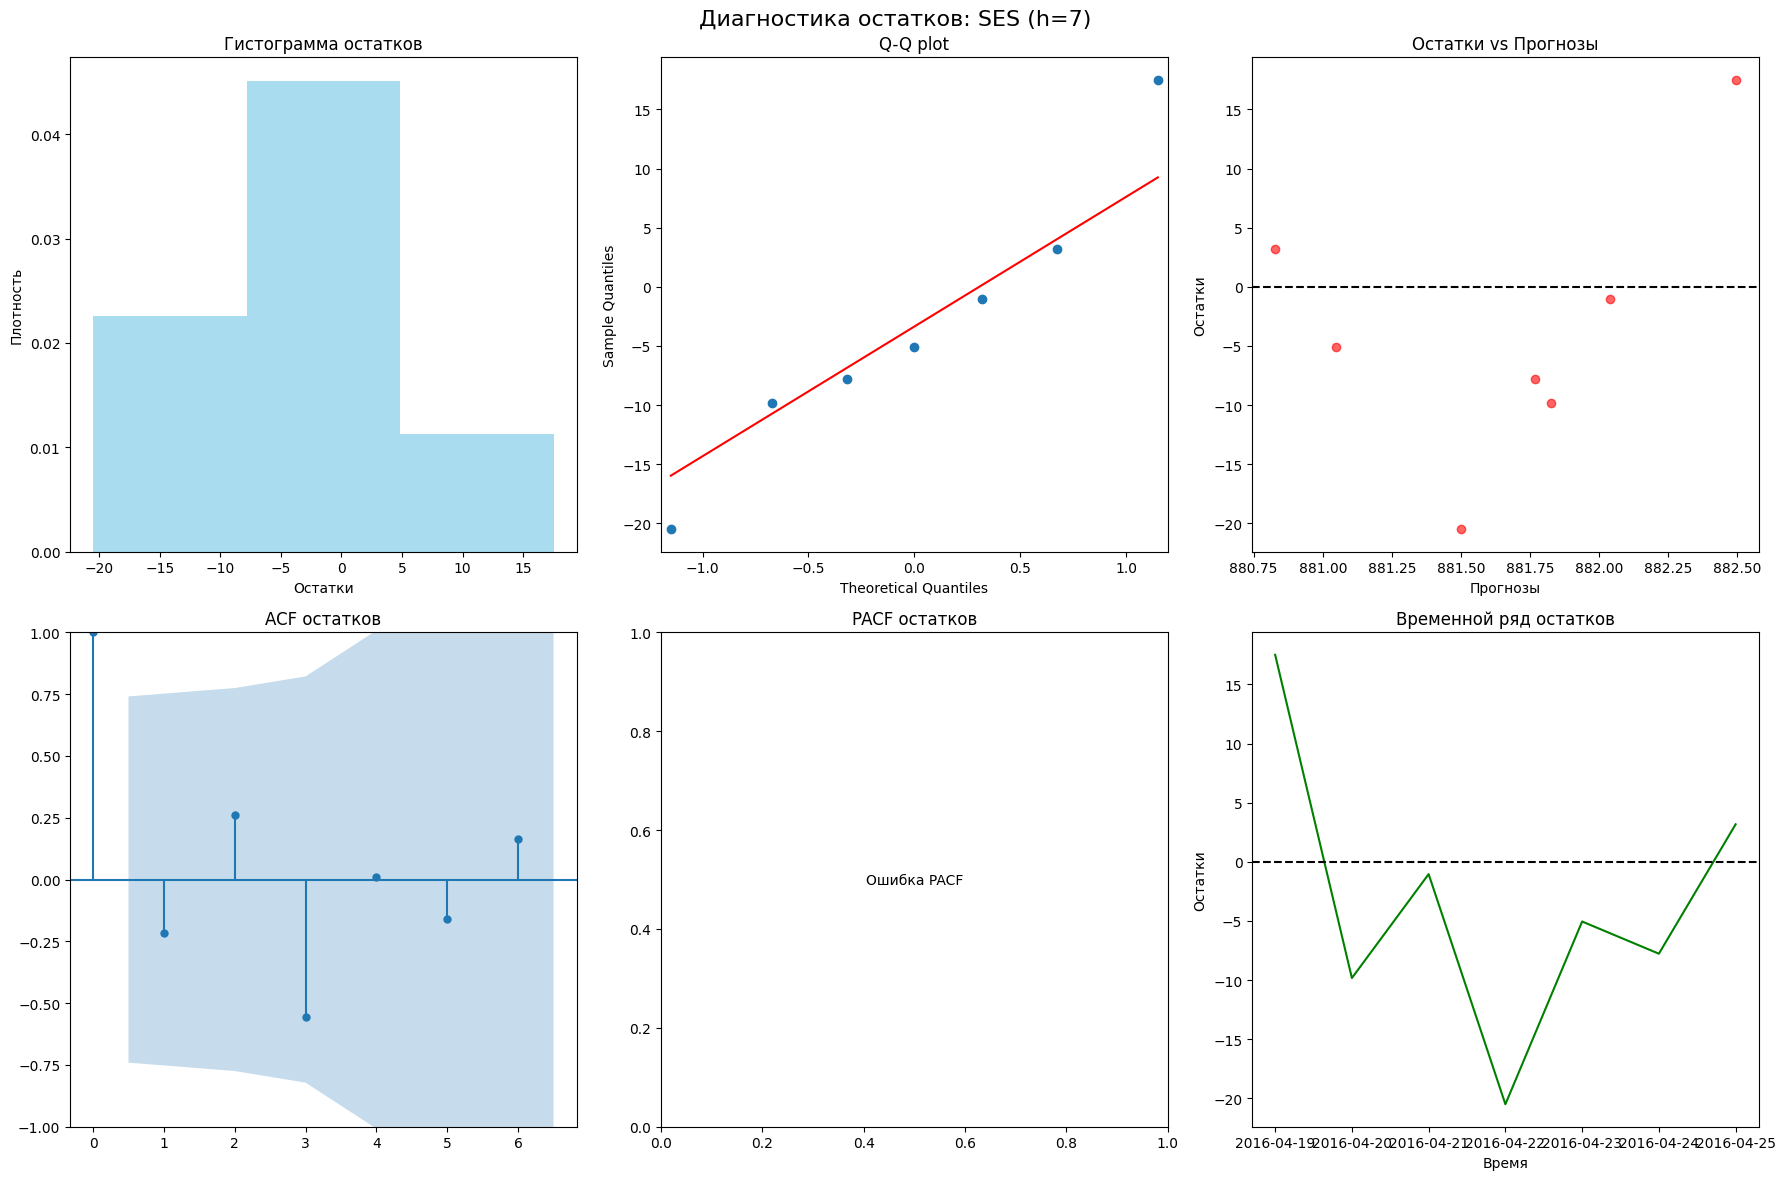

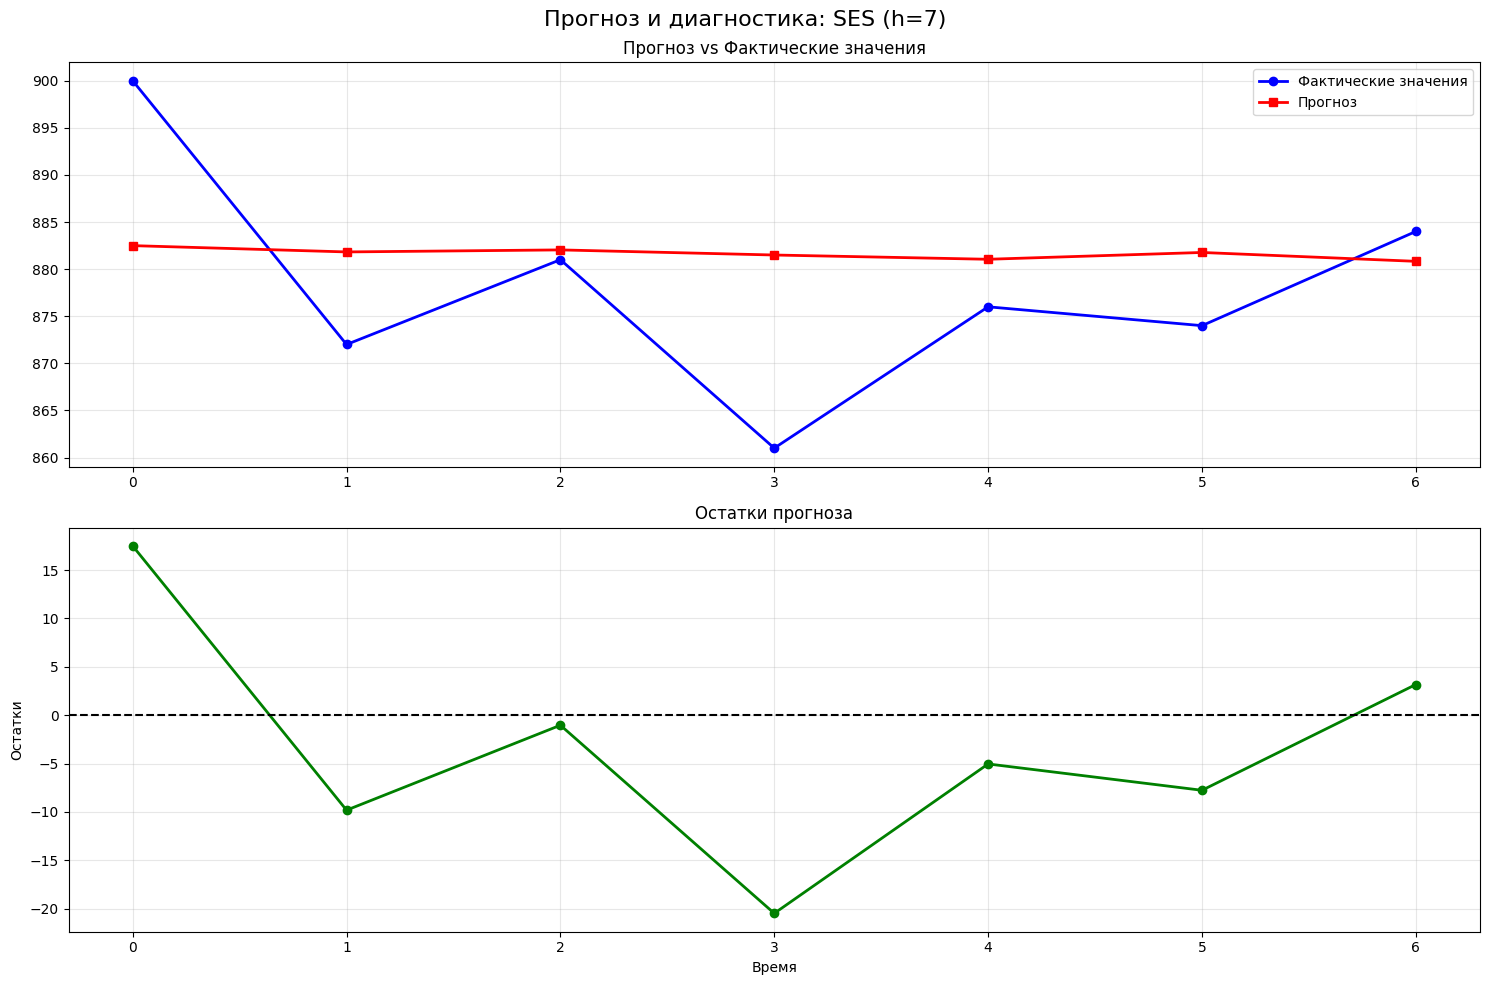


--- Модель: ARIMA ---

ДИАГНОСТИКА МОДЕЛИ: ARIMA (h=7)
Статистика остатков:
  Количество точек: 7
  Среднее: -2.5742
  Стандартное отклонение: 11.1736
  Минимум: -19.8615
  Максимум: 19.1503

1. Тест Льюнга-Бокса:
   p-value: 0.1204
   Остатки - белый шум: ДА
Shapiro-Wilk test error: name 'stats' is not defined

2. Тесты на нормальность:
   Харке-Бера: p-value = 0.8590
   Асимметрия: 0.5073, Эксцесс: 2.8878

3. Тест Бройша-Пагана:
   p-value: 0.1120
   Гомоскедастичность: ДА


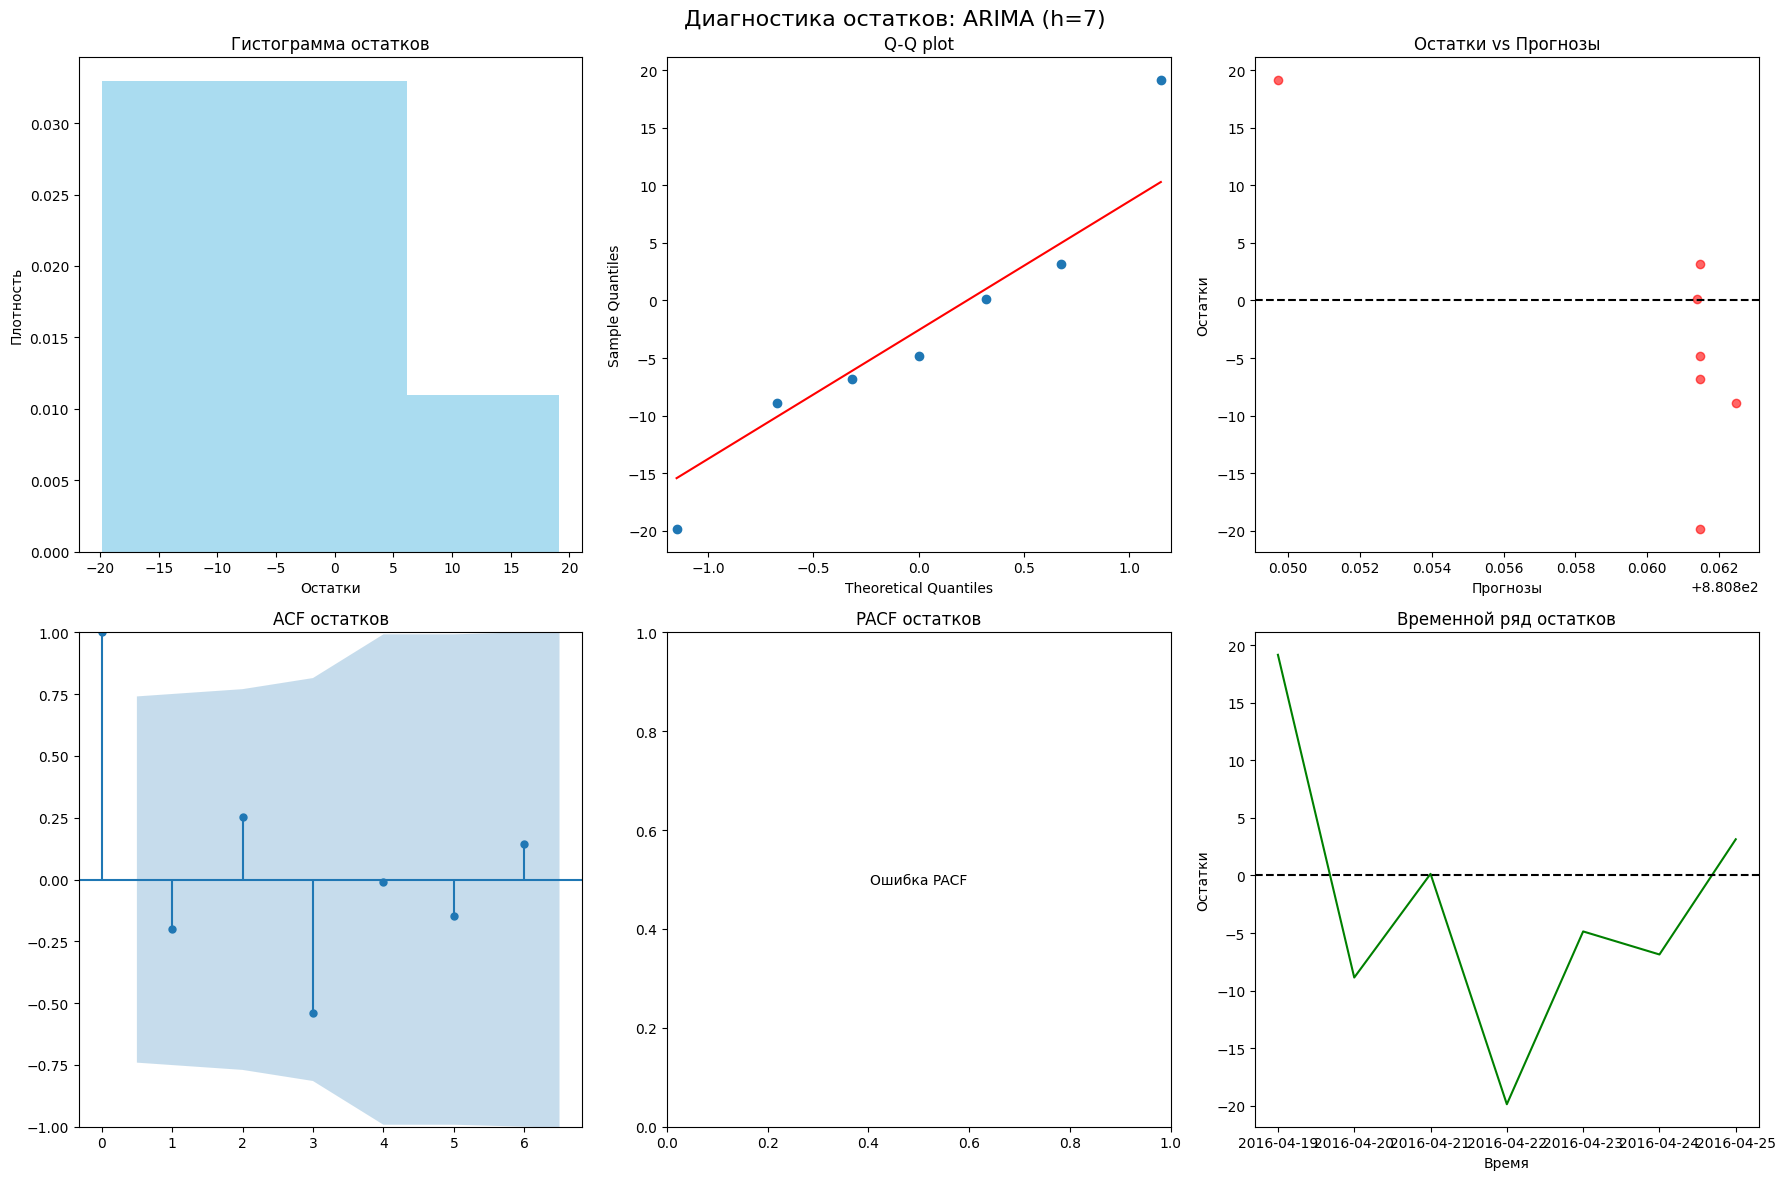

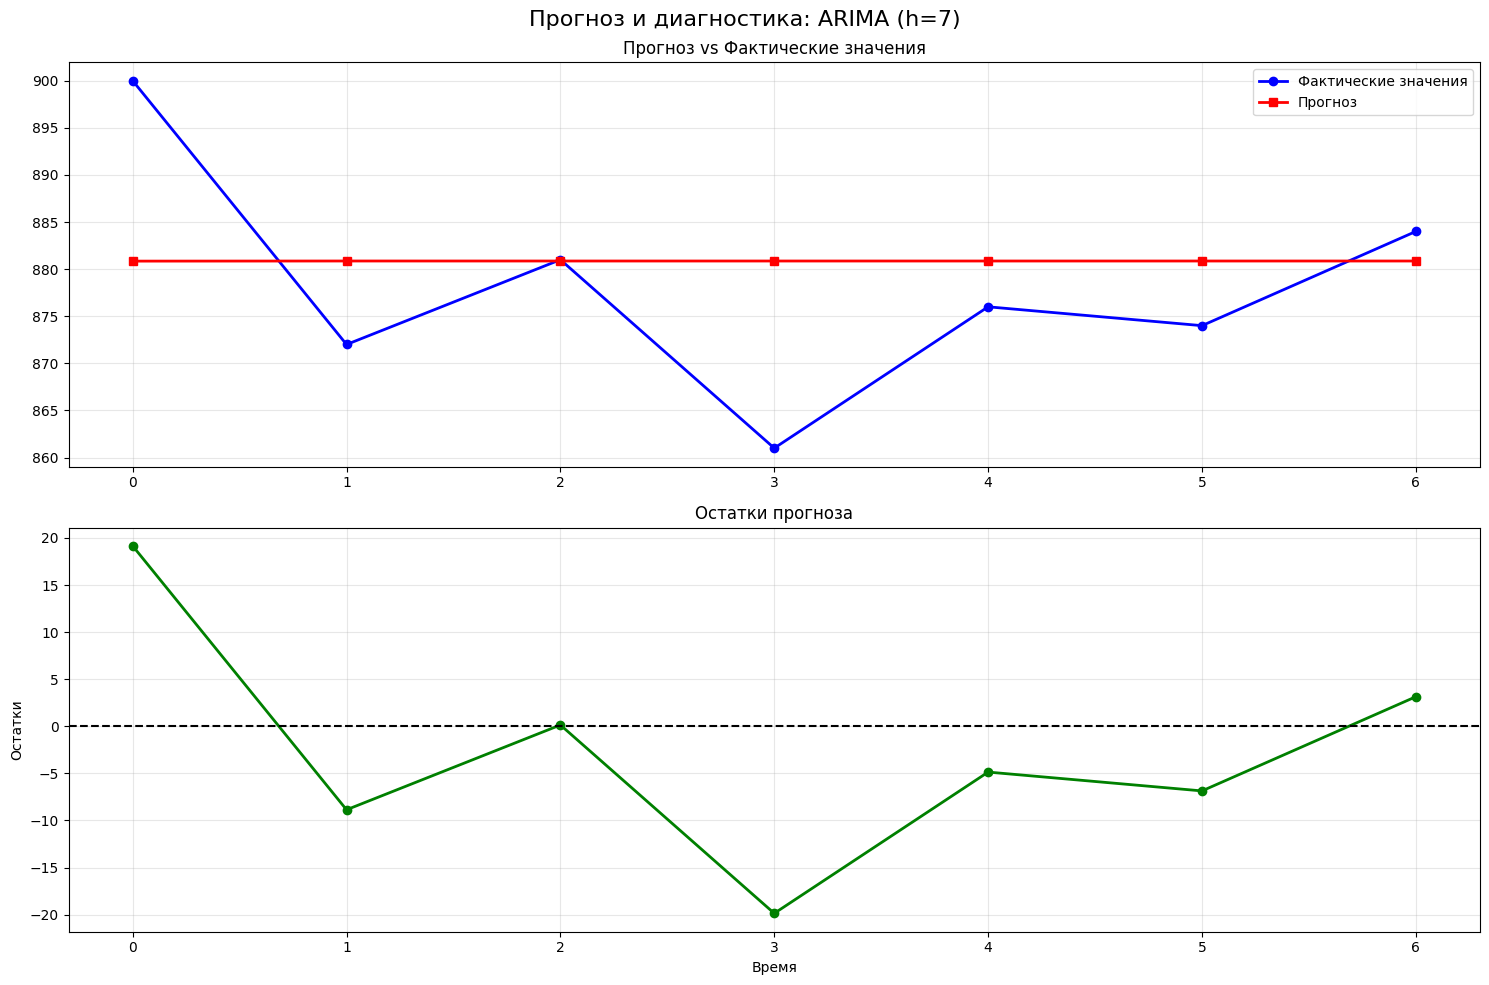


ГОРИЗОНТ ПРОГНОЗИРОВАНИЯ: 30

--- Модель: TBATS ---

ДИАГНОСТИКА МОДЕЛИ: TBATS (h=30)
Статистика остатков:
  Количество точек: 30
  Среднее: -5.7694
  Стандартное отклонение: 10.2509
  Минимум: -26.7492
  Максимум: 18.7463

1. Тест Льюнга-Бокса:
   p-value: 0.4292
   Остатки - белый шум: ДА
Shapiro-Wilk test error: name 'stats' is not defined

2. Тесты на нормальность:
   Харке-Бера: p-value = 0.9407
   Асимметрия: 0.1403, Эксцесс: 2.8618

3. Тест Бройша-Пагана:
   p-value: 0.2558
   Гомоскедастичность: ДА


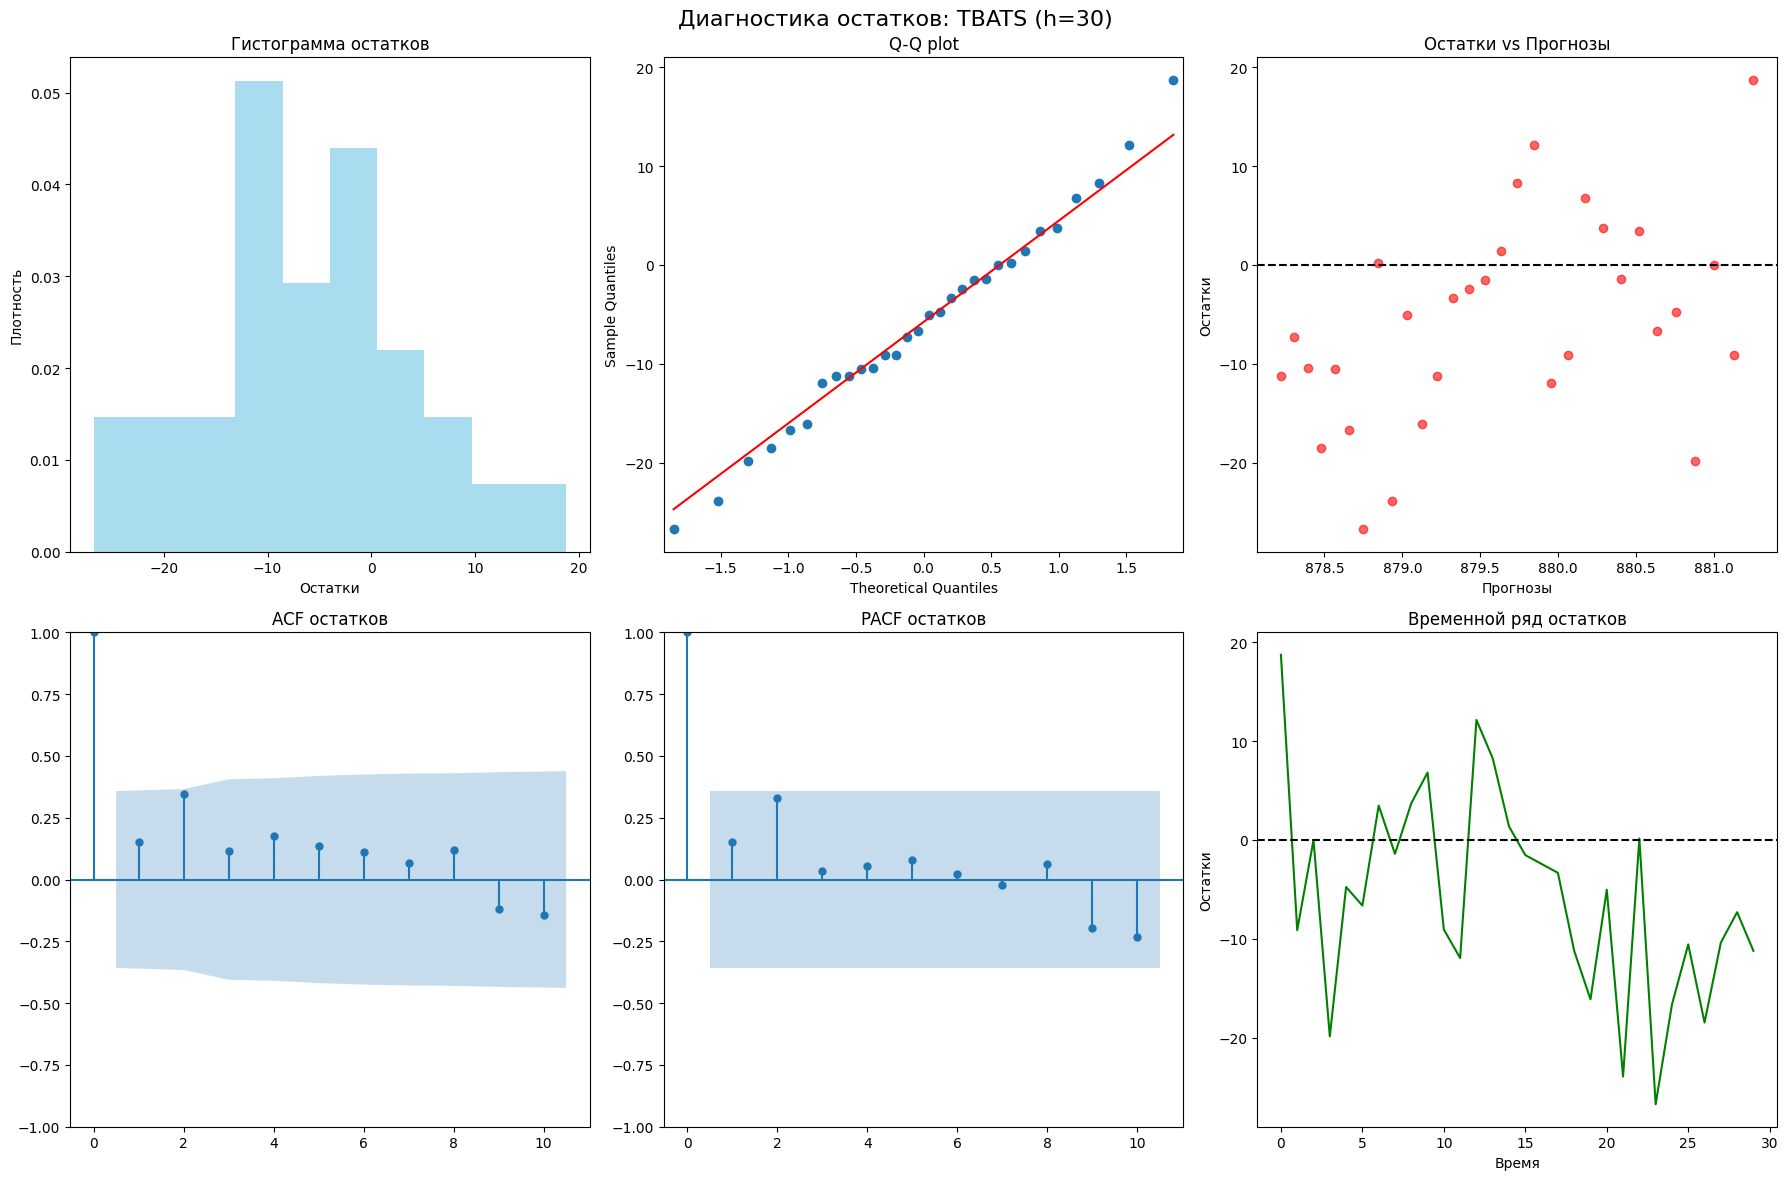

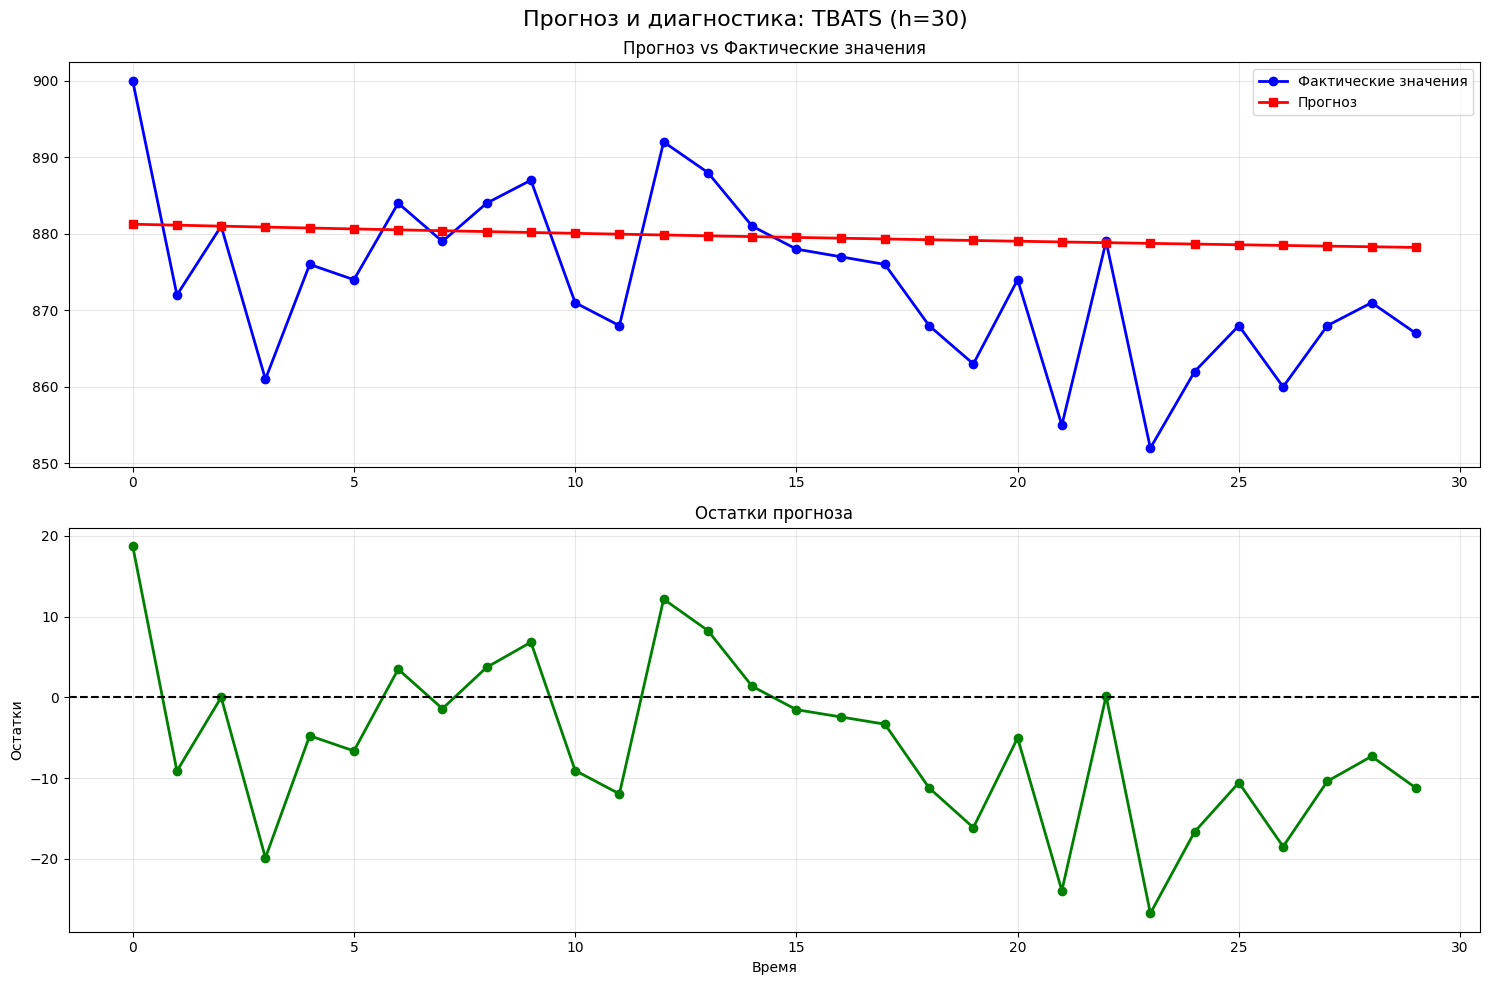


--- Модель: SES ---

ДИАГНОСТИКА МОДЕЛИ: SES (h=30)
Статистика остатков:
  Количество точек: 30
  Среднее: -6.3629
  Стандартное отклонение: 10.1476
  Минимум: -27.4345
  Максимум: 17.5061

1. Тест Льюнга-Бокса:
   p-value: 0.4778
   Остатки - белый шум: ДА
Shapiro-Wilk test error: name 'stats' is not defined

2. Тесты на нормальность:
   Харке-Бера: p-value = 0.9729
   Асимметрия: 0.0832, Эксцесс: 2.8722

3. Тест Бройша-Пагана:
   p-value: 0.4538
   Гомоскедастичность: ДА


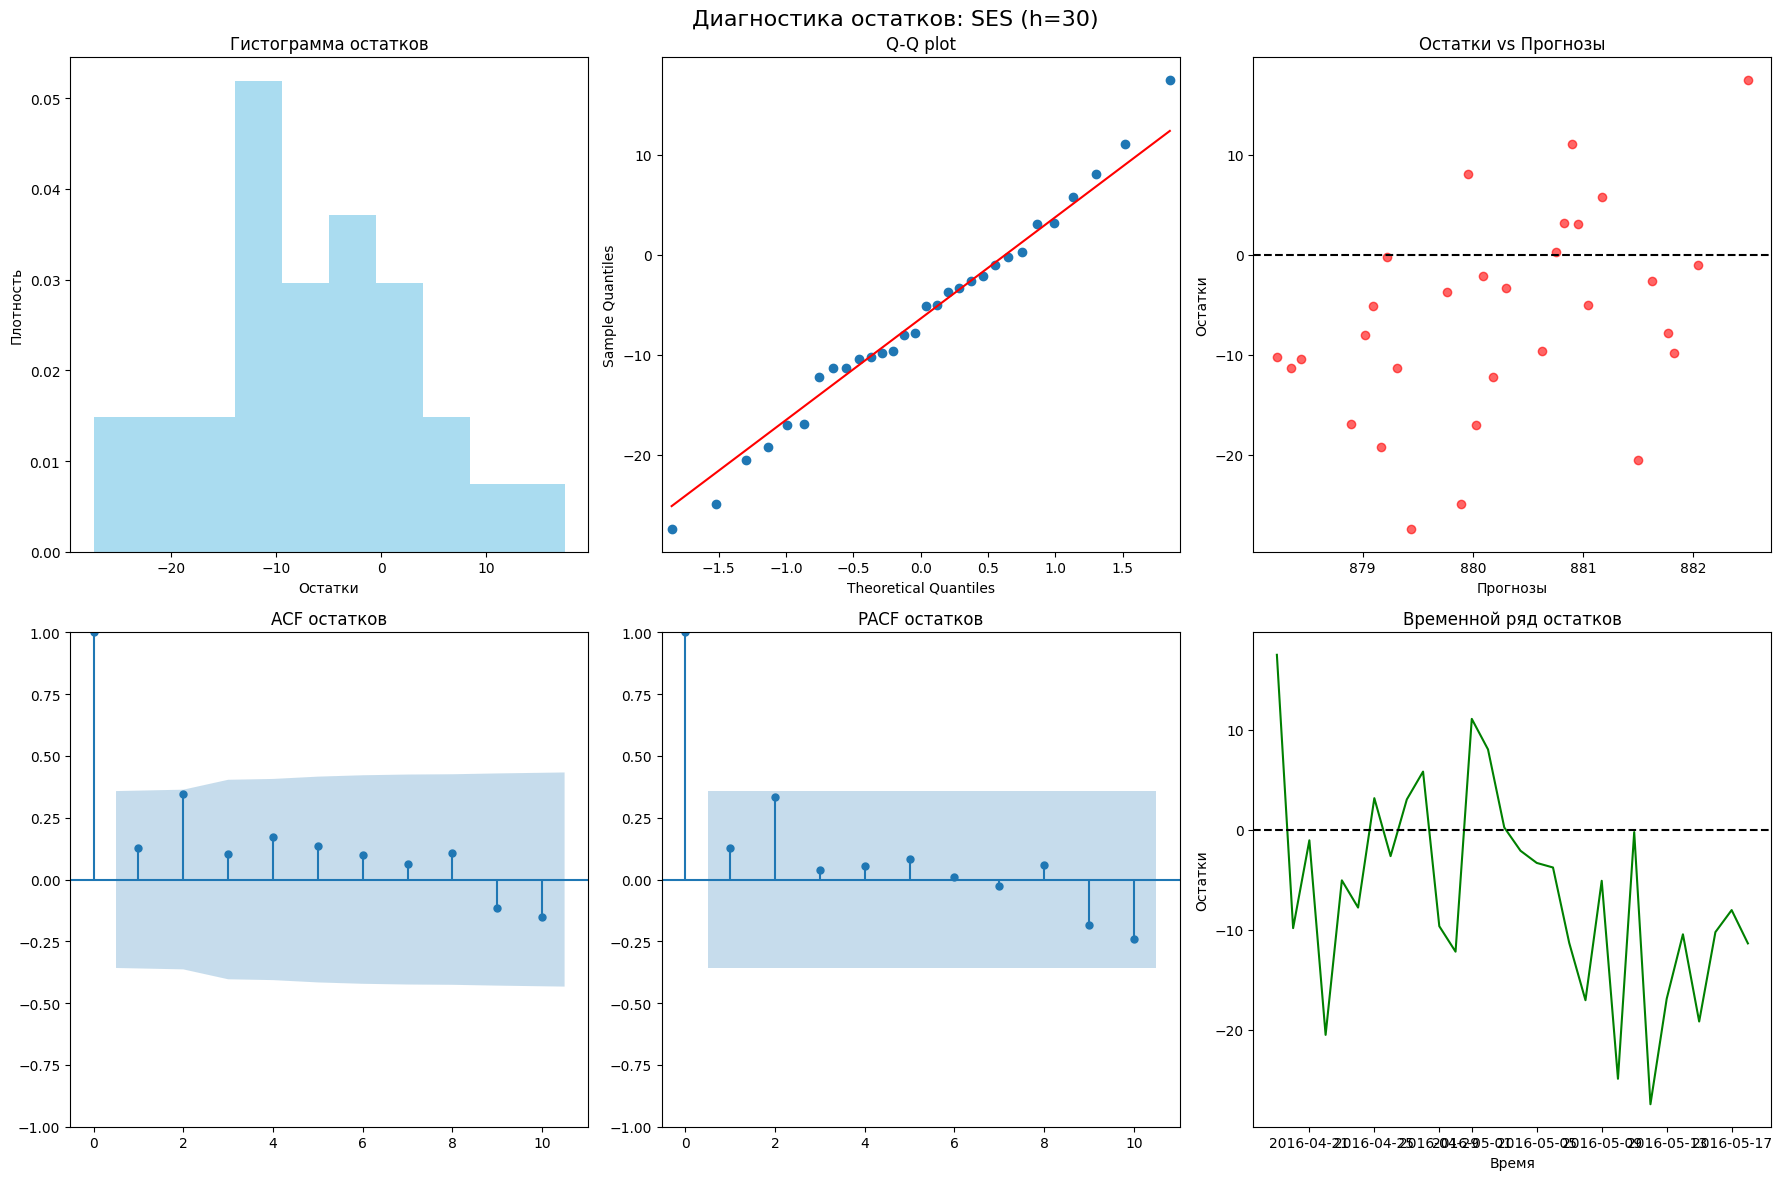

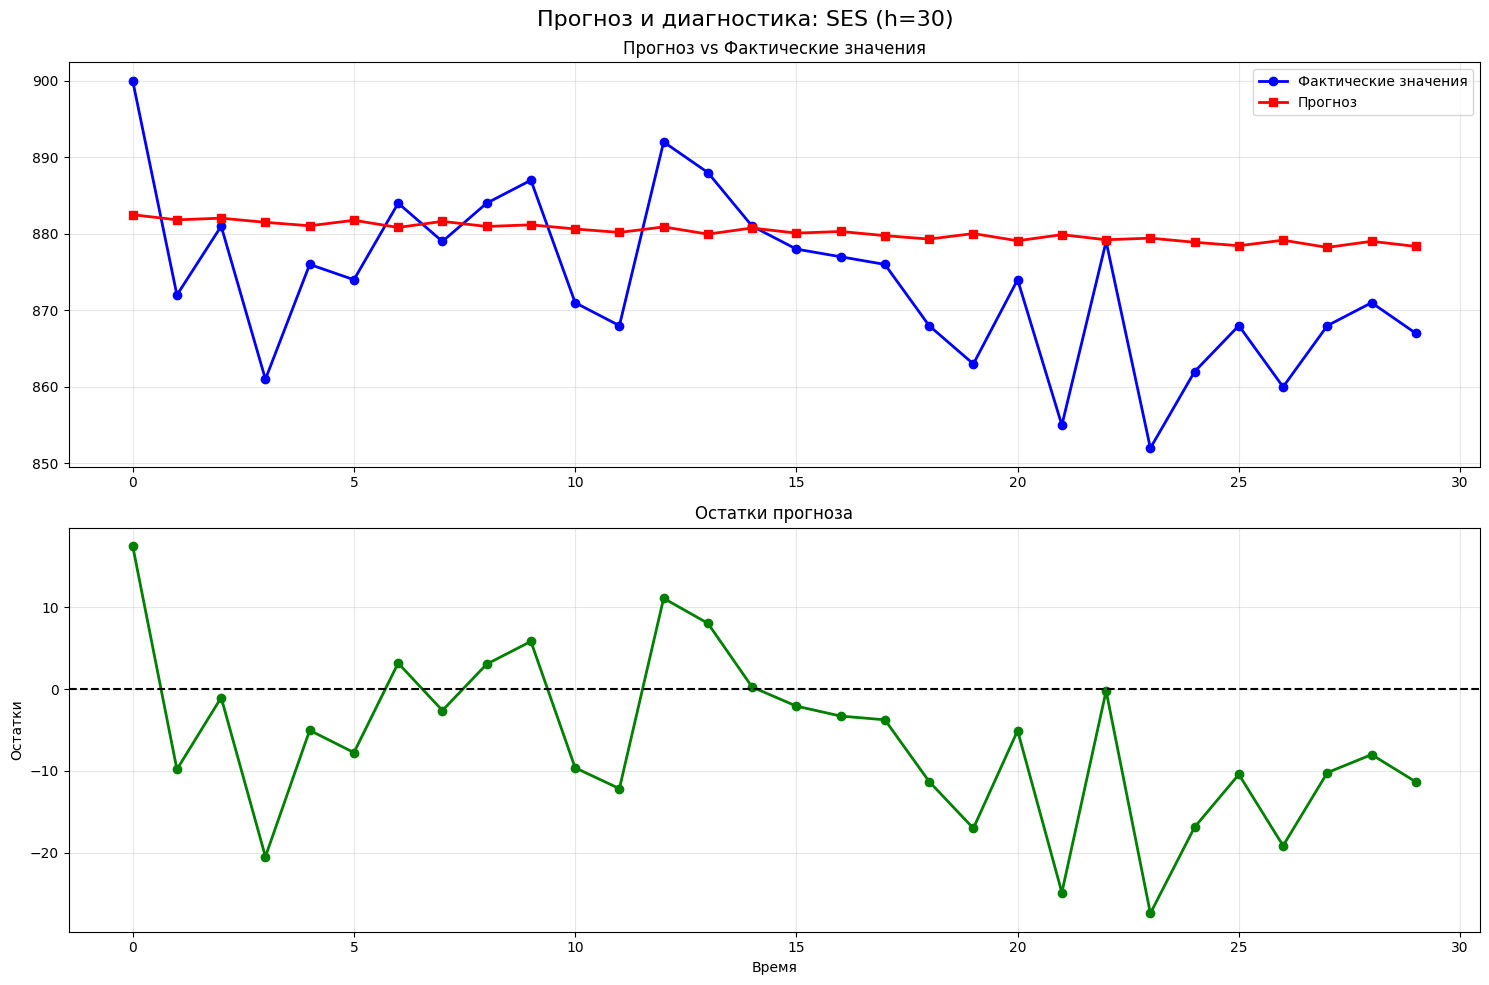


--- Модель: ARIMA ---

ДИАГНОСТИКА МОДЕЛИ: ARIMA (h=30)
Статистика остатков:
  Количество точек: 30
  Среднее: -6.9944
  Стандартное отклонение: 10.7022
  Минимум: -28.8615
  Максимум: 19.1503

1. Тест Льюнга-Бокса:
   p-value: 0.1840
   Остатки - белый шум: ДА
Shapiro-Wilk test error: name 'stats' is not defined

2. Тесты на нормальность:
   Харке-Бера: p-value = 0.9271
   Асимметрия: 0.1634, Эксцесс: 2.8807

3. Тест Бройша-Пагана:
   p-value: 0.2993
   Гомоскедастичность: ДА


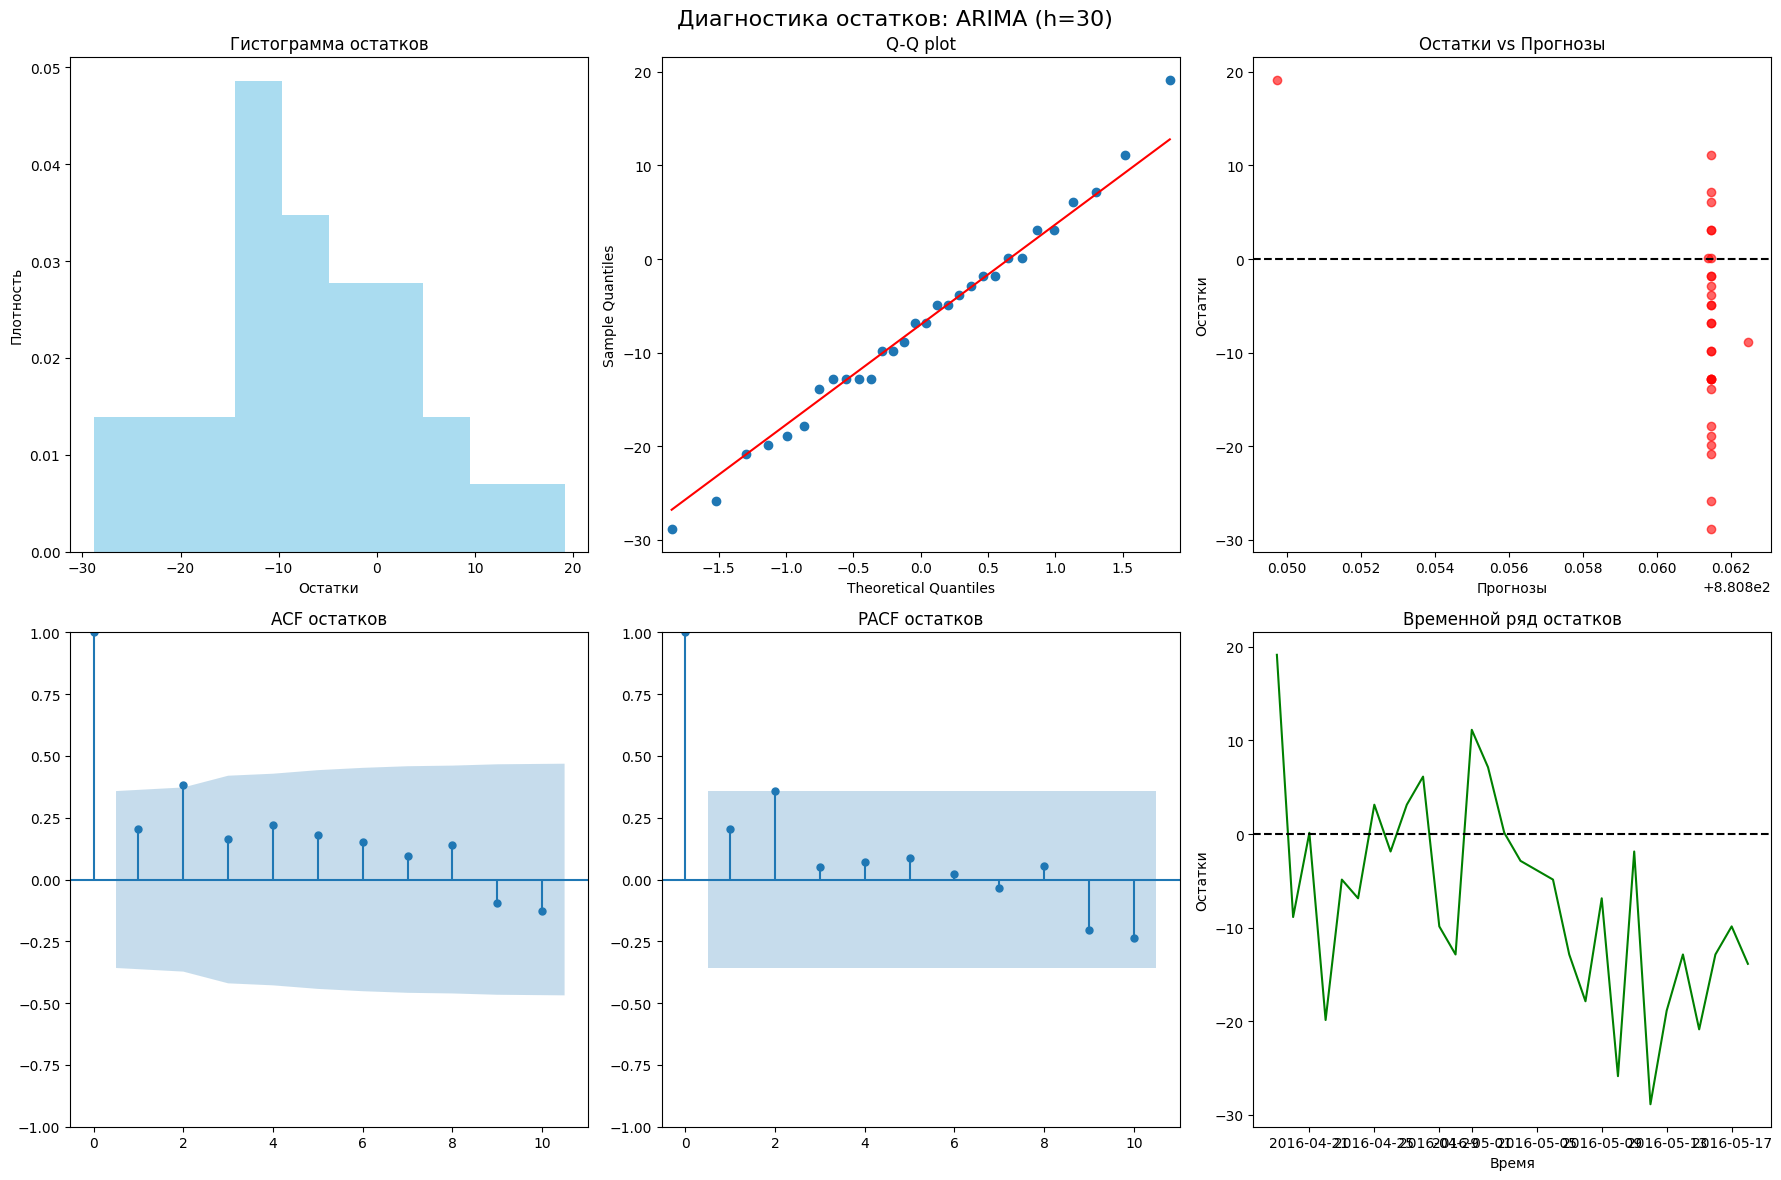

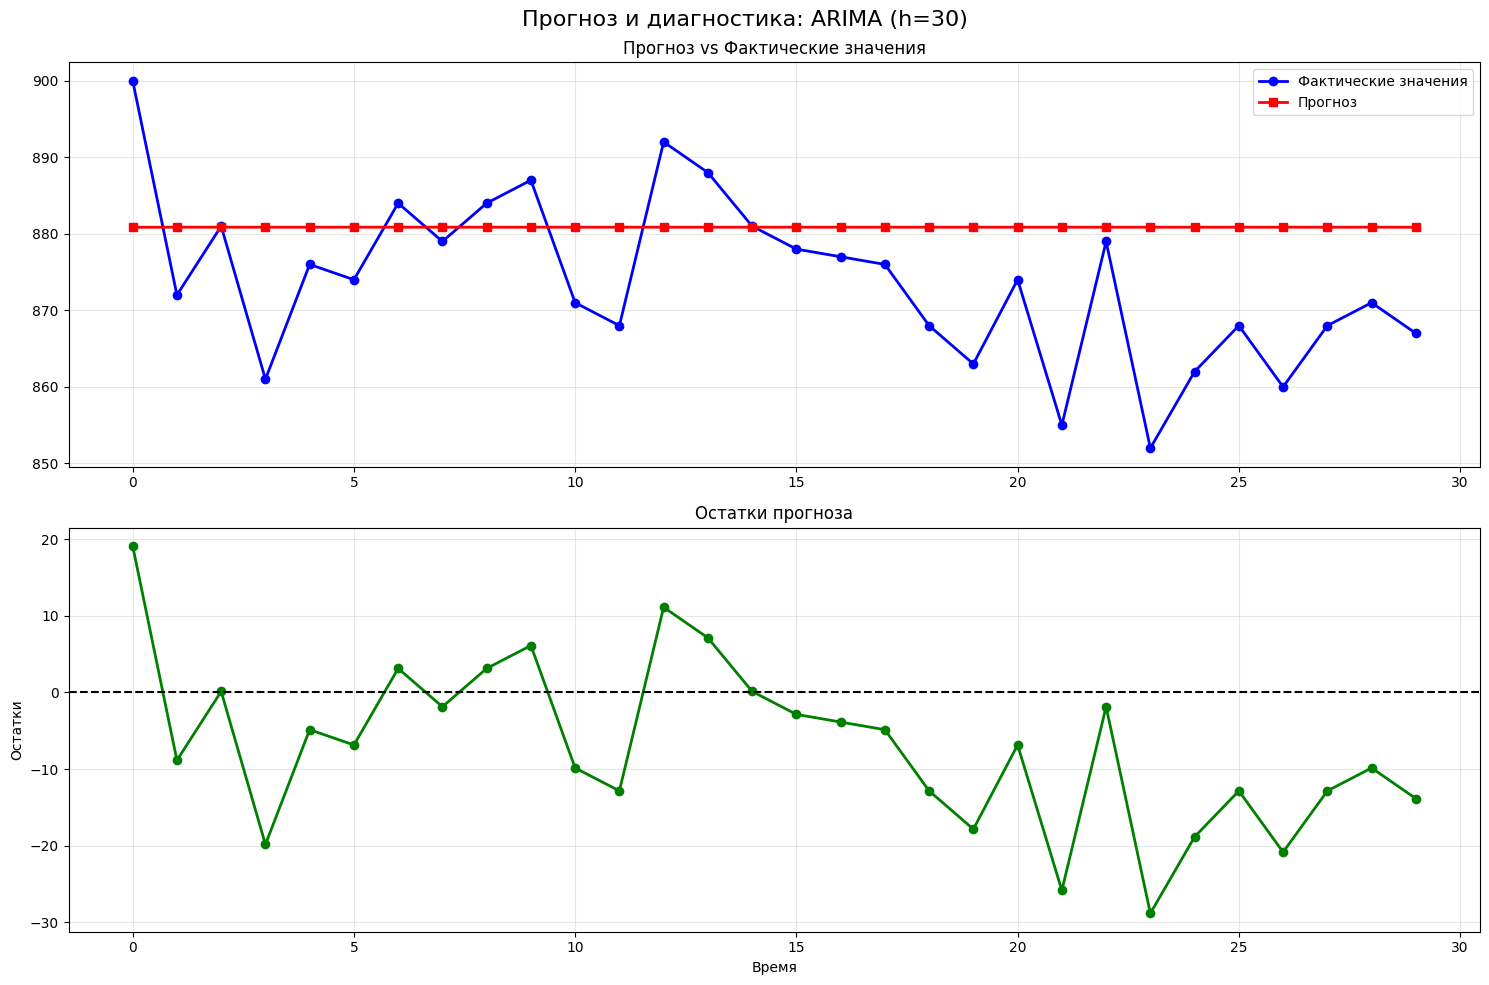


=== СВОДНАЯ ДИАГНОСТИКА ТОП-МОДЕЛЕЙ ===
Модель               Горизонт   Белый шум    Нормальность   Гомоскедаст.   RMSE      
TBATS                7          ✓            -              ✓              11.76     
SES                  7          ✓            -              ✓              11.98     
ARIMA                7          ✓            -              ✓              12.79     
TBATS                30         ✓            -              ✓              11.76     
SES                  30         ✓            -              ✓              11.98     
ARIMA                30         ✓            -              ✓              12.79     

Диагностика завершена для 3 моделей на горизонтах [7, 30]


In [23]:
def ljung_box_test(residuals, lags=None):
    """Тест Льюнга-Бокса на автокорреляцию остатков"""
    if len(residuals) < 5:
        return None, None
        
    if lags is None:
        lags = min(10, len(residuals) // 2)
    
    try:
        lb_test = acorr_ljungbox(residuals, lags=lags, return_df=True)
        p_value = lb_test['lb_pvalue'].iloc[-1]
        return p_value, lb_test
    except Exception as e:
        print(f"Ljung-Box test error: {e}")
        return None, None

def breusch_pagan_test(residuals, fitted_values):
    """Тест Бройша-Пагана на гетероскедастичность"""
    if len(residuals) < 3:
        return None
        
    try:
        X = np.column_stack([np.ones_like(fitted_values), fitted_values])
        bp_test = het_breuschpagan(residuals, X)
        return {
            'lm_statistic': bp_test[0],
            'lm_pvalue': bp_test[1],
            'f_statistic': bp_test[2],
            'f_pvalue': bp_test[3]
        }
    except Exception as e:
        print(f"Breusch-Pagan test error: {e}")
        return None

def shapiro_wilk_test(residuals):
    """Тест Шапиро-Уилка на нормальность"""
    if len(residuals) < 3:
        return None, None
        
    try:
        stat, p_value = stats.shapiro(residuals)
        return stat, p_value
    except Exception as e:
        print(f"Shapiro-Wilk test error: {e}")
        return None, None

def jarque_bera_test(residuals):
    """Тест Харке-Бера на нормальность"""
    if len(residuals) < 3:
        return None, None, None, None
        
    try:
        jb_stat, jb_pvalue, skewness, kurtosis = jarque_bera(residuals)
        return jb_stat, jb_pvalue, skewness, kurtosis
    except Exception as e:
        print(f"Jarque-Bera test error: {e}")
        return None, None, None, None

def plot_residuals_diagnostics(residuals, fitted_values, model_name, horizon):
    """Визуализация диагностики остатков"""
    n_plots = 6
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Диагностика остатков: {model_name} (h={horizon})', fontsize=16)
    
    # 1. Распределение остатков
    if len(residuals) > 1:
        axes[0, 0].hist(residuals, bins=min(10, len(residuals)//2), density=True, alpha=0.7, color='skyblue')
        axes[0, 0].set_title('Гистограмма остатков')
        axes[0, 0].set_xlabel('Остатки')
        axes[0, 0].set_ylabel('Плотность')
    else:
        axes[0, 0].text(0.5, 0.5, 'Недостаточно данных', ha='center', va='center')
        axes[0, 0].set_title('Гистограмма остатков')
    
    # 2. Q-Q plot
    if len(residuals) > 2:
        qqplot(residuals, line='s', ax=axes[0, 1])
        axes[0, 1].set_title('Q-Q plot')
    else:
        axes[0, 1].text(0.5, 0.5, 'Недостаточно данных', ha='center', va='center')
        axes[0, 1].set_title('Q-Q plot')
    
    # 3. Остатки vs fitted values
    if len(residuals) > 1:
        axes[0, 2].scatter(fitted_values, residuals, alpha=0.6, color='red')
        axes[0, 2].axhline(y=0, color='black', linestyle='--')
        axes[0, 2].set_title('Остатки vs Прогнозы')
        axes[0, 2].set_xlabel('Прогнозы')
        axes[0, 2].set_ylabel('Остатки')
    else:
        axes[0, 2].text(0.5, 0.5, 'Недостаточно данных', ha='center', va='center')
        axes[0, 2].set_title('Остатки vs Прогнозы')
    
    # 4. ACF остатков
    if len(residuals) > 5:
        try:
            plot_acf(residuals, ax=axes[1, 0], lags=min(10, len(residuals)-1), alpha=0.05)
            axes[1, 0].set_title('ACF остатков')
        except:
            axes[1, 0].text(0.5, 0.5, 'Ошибка ACF', ha='center', va='center')
            axes[1, 0].set_title('ACF остатков')
    else:
        axes[1, 0].text(0.5, 0.5, 'Недостаточно данных', ha='center', va='center')
        axes[1, 0].set_title('ACF остатков')
    
    # 5. PACF остатков
    if len(residuals) > 5:
        try:
            plot_pacf(residuals, ax=axes[1, 1], lags=min(10, len(residuals)-1), alpha=0.05)
            axes[1, 1].set_title('PACF остатков')
        except:
            axes[1, 1].text(0.5, 0.5, 'Ошибка PACF', ha='center', va='center')
            axes[1, 1].set_title('PACF остатков')
    else:
        axes[1, 1].text(0.5, 0.5, 'Недостаточно данных', ha='center', va='center')
        axes[1, 1].set_title('PACF остатков')
    
    # 6. Временной ряд остатков
    if len(residuals) > 1:
        axes[1, 2].plot(residuals, color='green')
        axes[1, 2].axhline(y=0, color='black', linestyle='--')
        axes[1, 2].set_title('Временной ряд остатков')
        axes[1, 2].set_xlabel('Время')
        axes[1, 2].set_ylabel('Остатки')
    else:
        axes[1, 2].text(0.5, 0.5, 'Недостаточно данных', ha='center', va='center')
        axes[1, 2].set_title('Временной ряд остатков')
    
    plt.tight_layout()
    plt.show()

def plot_forecast_with_ci(actual, forecast, ci, model_name, horizon, residuals=None):
    """Визуализация прогноза с доверительными интервалами и остатками"""
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle(f'Прогноз и диагностика: {model_name} (h={horizon})', fontsize=16)
    
    # Верхний график: прогноз
    time_index = range(len(actual))
    axes[0].plot(time_index, actual, label='Фактические значения', color='blue', linewidth=2, marker='o')
    axes[0].plot(time_index, forecast, label='Прогноз', color='red', linewidth=2, marker='s')
    
    if ci is not None and len(ci) == len(actual):
        axes[0].fill_between(time_index, ci.iloc[:, 0], ci.iloc[:, 1], 
                           alpha=0.3, color='red', label='95% ДИ')
    
    axes[0].set_title('Прогноз vs Фактические значения')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Нижний график: остатки
    if residuals is not None and len(residuals) > 0:
        axes[1].plot(time_index[:len(residuals)], residuals, color='green', linewidth=2, marker='o')
        axes[1].axhline(y=0, color='black', linestyle='--')
        axes[1].set_title('Остатки прогноза')
        axes[1].set_xlabel('Время')
        axes[1].set_ylabel('Остатки')
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'Нет данных об остатках', ha='center', va='center')
        axes[1].set_title('Остатки прогноза')
    
    plt.tight_layout()
    plt.show()

def calculate_residuals(actual, forecast):
    """Вычисление остатков"""
    min_len = min(len(actual), len(forecast))
    if min_len == 0:
        return np.array([])
    return actual[:min_len] - forecast[:min_len]

def model_diagnostics(model_result, actual, forecast, ci, model_name, horizon):
    """Полная диагностика модели"""
    print(f"\n{'='*60}")
    print(f"ДИАГНОСТИКА МОДЕЛИ: {model_name} (h={horizon})")
    print(f"{'='*60}")
    
    # Вычисляем остатки
    residuals = calculate_residuals(actual, forecast)
    
    if len(residuals) < 3:
        print("Недостаточно данных для диагностики (нужно минимум 3 точки)")
        return None
    
    # Базовая статистика остатков
    print(f"Статистика остатков:")
    print(f"  Количество точек: {len(residuals)}")
    print(f"  Среднее: {np.mean(residuals):.4f}")
    print(f"  Стандартное отклонение: {np.std(residuals):.4f}")
    if len(residuals) > 1:
        print(f"  Минимум: {np.min(residuals):.4f}")
        print(f"  Максимум: {np.max(residuals):.4f}")
    
    diagnostic_results = {}
    
    # 1. Тест Льюнга-Бокса
    lb_pvalue, lb_test = ljung_box_test(residuals)
    if lb_pvalue is not None:
        print(f"\n1. Тест Льюнга-Бокса:")
        print(f"   p-value: {lb_pvalue:.4f}")
        print(f"   Остатки - белый шум: {'ДА' if lb_pvalue > 0.05 else 'НЕТ'}")
        diagnostic_results['ljung_box_pvalue'] = lb_pvalue
        diagnostic_results['is_white_noise'] = lb_pvalue > 0.05
    else:
        diagnostic_results['ljung_box_pvalue'] = None
        diagnostic_results['is_white_noise'] = None
    
    # 2. Тесты на нормальность
    sw_stat, sw_pvalue = shapiro_wilk_test(residuals)
    jb_stat, jb_pvalue, skewness, kurtosis = jarque_bera_test(residuals)
    
    print(f"\n2. Тесты на нормальность:")
    if sw_pvalue is not None:
        print(f"   Шапиро-Уилк: p-value = {sw_pvalue:.4f}")
        print(f"   Нормальность: {'ДА' if sw_pvalue > 0.05 else 'НЕТ'}")
        diagnostic_results['shapiro_pvalue'] = sw_pvalue
        diagnostic_results['is_normal_sw'] = sw_pvalue > 0.05
    else:
        diagnostic_results['shapiro_pvalue'] = None
        diagnostic_results['is_normal_sw'] = None
    
    if jb_pvalue is not None:
        print(f"   Харке-Бера: p-value = {jb_pvalue:.4f}")
        print(f"   Асимметрия: {skewness:.4f}, Эксцесс: {kurtosis:.4f}")
        diagnostic_results['jarque_bera_pvalue'] = jb_pvalue
        diagnostic_results['is_normal_jb'] = jb_pvalue > 0.05
        diagnostic_results['skewness'] = skewness
        diagnostic_results['kurtosis'] = kurtosis
    else:
        diagnostic_results['jarque_bera_pvalue'] = None
        diagnostic_results['is_normal_jb'] = None
        diagnostic_results['skewness'] = None
        diagnostic_results['kurtosis'] = None
    
    # 3. Тест на гетероскедастичность
    fitted_for_test = forecast[:len(residuals)]
    bp_result = breusch_pagan_test(residuals, fitted_for_test)
    if bp_result is not None:
        print(f"\n3. Тест Бройша-Пагана:")
        print(f"   p-value: {bp_result['lm_pvalue']:.4f}")
        print(f"   Гомоскедастичность: {'ДА' if bp_result['lm_pvalue'] > 0.05 else 'НЕТ'}")
        diagnostic_results['breusch_pagan_pvalue'] = bp_result['lm_pvalue']
        diagnostic_results['is_homoscedastic'] = bp_result['lm_pvalue'] > 0.05
    else:
        diagnostic_results['breusch_pagan_pvalue'] = None
        diagnostic_results['is_homoscedastic'] = None
    
    # 4. Визуализация
    plot_residuals_diagnostics(residuals, fitted_for_test, model_name, horizon)
    plot_forecast_with_ci(actual, forecast, ci, model_name, horizon, residuals)
    
    # Сводный результат диагностики
    diagnostic_summary = {
        'model': model_name,
        'horizon': horizon,
        'residuals_count': len(residuals),
        'residuals_mean': np.mean(residuals),
        'residuals_std': np.std(residuals),
        **diagnostic_results
    }
    
    return diagnostic_summary

def get_top_models(models_results, n_top=3):
    """Выбор топ-N моделей по RMSE"""
    valid_results = []
    for model_name, result in models_results.items():
        if result is not None and result['rmse'] is not None:
            valid_results.append((model_name, result))
    
    valid_results.sort(key=lambda x: x[1]['rmse'])
    
    return valid_results[:n_top]

# Основной код диагностики
print("=== ДИАГНОСТИКА МОДЕЛЕЙ ===")

# Получаем топ-3 модели из предыдущего этапа
top_models = get_top_models(modeling_results['models'], n_top=3)

print(f"\nТоп-3 модели для диагностики:")
for i, (model_name, result) in enumerate(top_models, 1):
    print(f"{i}. {model_name}: RMSE = {result['rmse']:.2f}")

# Тестируем на разных горизонтах
horizons = [7, 30]  # Убрали горизонт 1, т.к. слишком мало данных для диагностики
diagnostics_results = {}

for horizon in horizons:
    print(f"\n{'='*80}")
    print(f"ГОРИЗОНТ ПРОГНОЗИРОВАНИЯ: {horizon}")
    print(f"{'='*80}")
    
    diagnostics_results[horizon] = {}
    
    for model_name, result in top_models:
        print(f"\n--- Модель: {model_name} ---")
        
        actual = feature_engineering_results['y_val'].values[:horizon]
        forecast = result['forecast'][:horizon] if len(result['forecast']) >= horizon else result['forecast']
        
        # Для коротких горизонтов используем все доступные данные
        if len(forecast) < horizon:
            print(f"  Предупреждение: прогноз содержит только {len(forecast)} точек вместо {horizon}")
            if len(forecast) < 3:
                print("  Пропускаем - недостаточно данных для диагностики")
                continue
        
        ci = None
        
        # Проводим диагностику
        diagnostic_summary = model_diagnostics(
            result, actual, forecast, ci, model_name, horizon
        )
        
        diagnostics_results[horizon][model_name] = diagnostic_summary

# Сводная таблица диагностики
print("\n=== СВОДНАЯ ДИАГНОСТИКА ТОП-МОДЕЛЕЙ ===")
print("=" * 100)
print(f"{'Модель':<20} {'Горизонт':<10} {'Белый шум':<12} {'Нормальность':<14} {'Гомоскедаст.':<14} {'RMSE':<10}")
print("=" * 100)

for horizon in horizons:
    for model_name, result in top_models:
        if model_name in diagnostics_results[horizon]:
            diag = diagnostics_results[horizon][model_name]
            if diag is not None:
                white_noise = "✓" if diag.get('is_white_noise') else "✗" if diag.get('is_white_noise') is not None else "-"
                normality = "✓" if diag.get('is_normal_sw') else "✗" if diag.get('is_normal_sw') is not None else "-"
                homoscedastic = "✓" if diag.get('is_homoscedastic') else "✗" if diag.get('is_homoscedastic') is not None else "-"
                
                rmse = result['rmse']
                
                print(f"{model_name:<20} {horizon:<10} {white_noise:<12} {normality:<14} {homoscedastic:<14} {rmse:<10.2f}")

# Сохранение результатов диагностики
diagnostics_final_results = {
    'diagnostics': diagnostics_results,
    'top_models': [model_name for model_name, _ in top_models],
    'horizons': horizons
}

print(f"\nДиагностика завершена для {len(top_models)} моделей на горизонтах {horizons}")

#### Оценка качества

=== КОМПЛЕКСНАЯ ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ ===

Error calculating metrics for ARIMA: name 'r2_score' is not defined
Error calculating metrics for ARIMA: name 'r2_score' is not defined
Error calculating metrics for ARIMA: name 'r2_score' is not defined
Error calculating metrics for SARIMA: name 'r2_score' is not defined
Error calculating metrics for SARIMA: name 'r2_score' is not defined
Error calculating metrics for SARIMA: name 'r2_score' is not defined
Error calculating metrics for GARCH: name 'r2_score' is not defined
Error calculating metrics for GARCH: name 'r2_score' is not defined
Error calculating metrics for GARCH: name 'r2_score' is not defined
Error calculating metrics for TBATS: name 'r2_score' is not defined
Error calculating metrics for TBATS: name 'r2_score' is not defined
Error calculating metrics for TBATS: name 'r2_score' is not defined
Error calculating metrics for Naive: name 'r2_score' is not defined
Error calculating metrics for Naive: name 'r2_score' is not defined


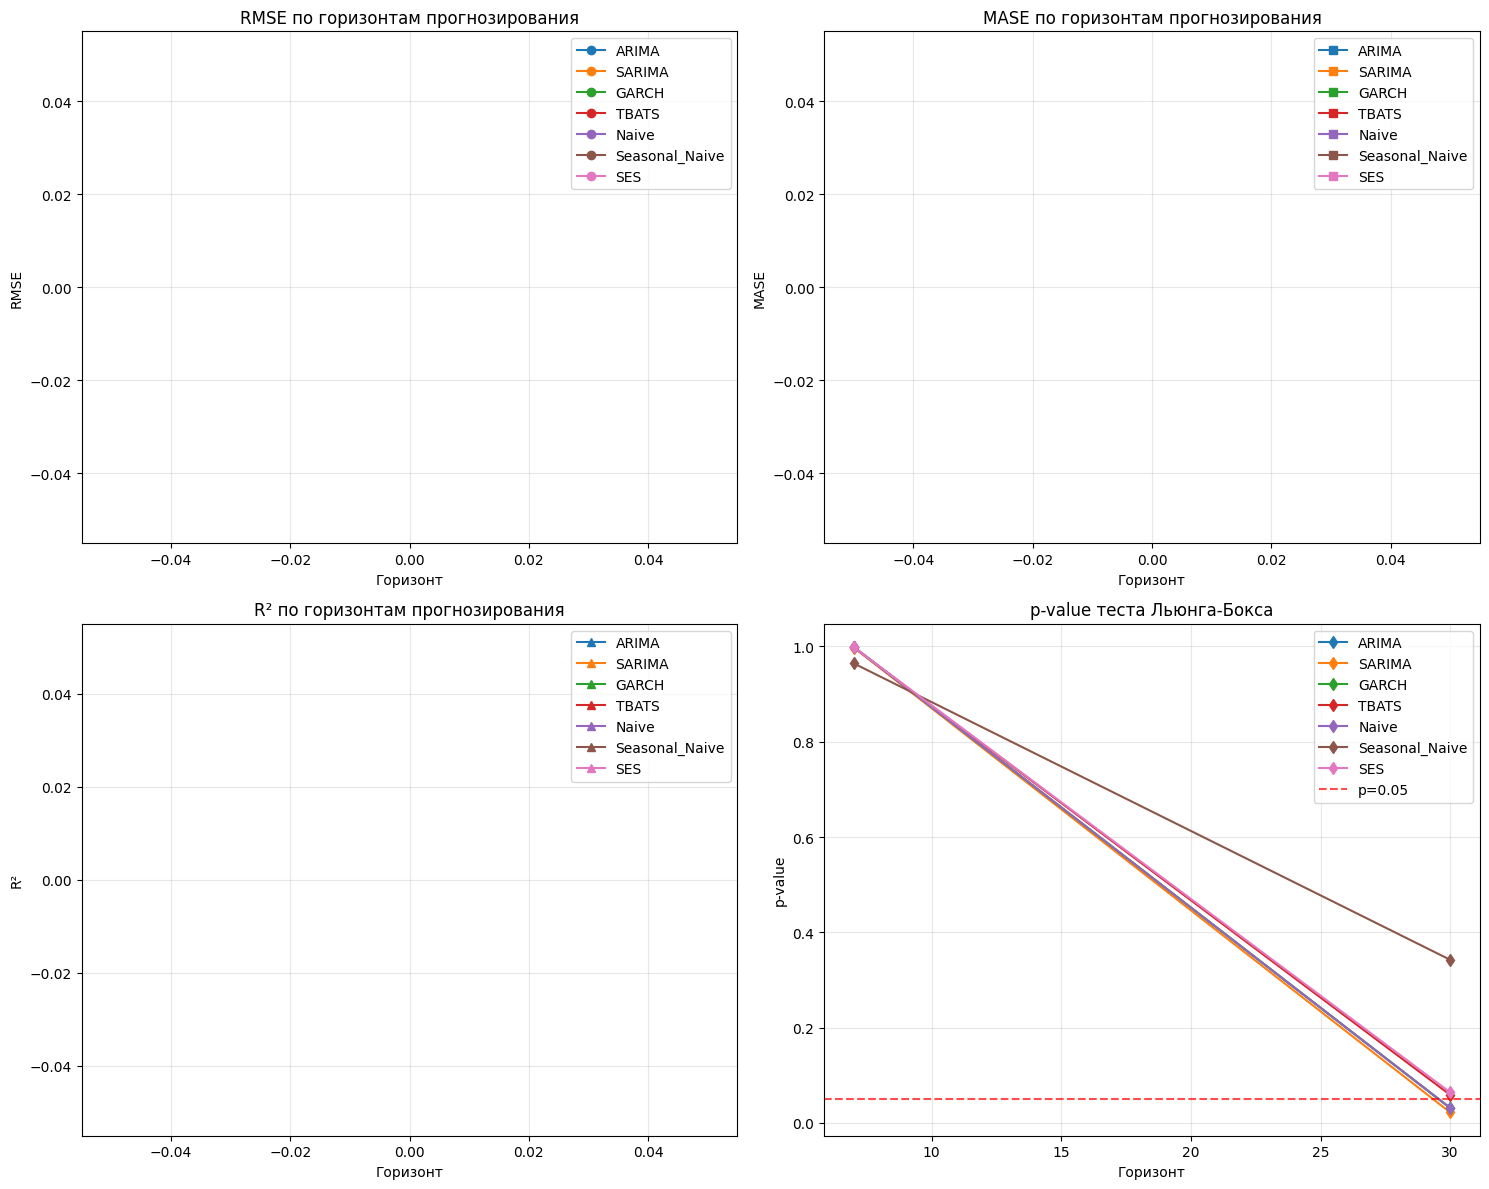


Оценка качества завершена для 7 моделей
Лучшая модель: Seasonal_Naive


In [24]:
def calculate_mape(actual, forecast):
    """Mean Absolute Percentage Error"""
    actual, forecast = np.array(actual), np.array(forecast)
    mask = actual != 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

def calculate_mase(actual, forecast, train_series, seasonality=1):
    """Mean Absolute Scaled Error"""
    naive_forecast = train_series.shift(seasonality).dropna()
    naive_error = np.mean(np.abs(train_series[seasonality:] - naive_forecast))
    if naive_error == 0:
        return np.nan
    forecast_error = np.mean(np.abs(actual - forecast))
    return forecast_error / naive_error

def calculate_smape(actual, forecast):
    """Symmetric Mean Absolute Percentage Error"""
    actual, forecast = np.array(actual), np.array(forecast)
    denominator = (np.abs(actual) + np.abs(forecast)) / 2
    mask = denominator != 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs(forecast[mask] - actual[mask]) / denominator[mask]) * 100

def calculate_rmsle(actual, forecast):
    """Root Mean Squared Logarithmic Error"""
    actual, forecast = np.array(actual), np.array(forecast)
    mask = (actual >= 0) & (forecast >= 0)
    if np.sum(mask) == 0:
        return np.nan
    return np.sqrt(np.mean((np.log1p(forecast[mask]) - np.log1p(actual[mask])) ** 2))

def calculate_all_metrics(actual, forecast, train_series=None, model_name=""):
    """Вычисление всех метрик качества"""
    if len(actual) != len(forecast):
        min_len = min(len(actual), len(forecast))
        actual = actual[:min_len]
        forecast = forecast[:min_len]
    
    if len(actual) == 0:
        return {}
    
    metrics = {}
    
    try:
        metrics['MAE'] = mean_absolute_error(actual, forecast)
        metrics['RMSE'] = np.sqrt(mean_squared_error(actual, forecast))
        metrics['MAPE'] = calculate_mape(actual, forecast)
        metrics['SMAPE'] = calculate_smape(actual, forecast)
        metrics['RMSLE'] = calculate_rmsle(actual, forecast)
        metrics['R2'] = r2_score(actual, forecast)
        
        if train_series is not None and len(train_series) > 1:
            metrics['MASE'] = calculate_mase(actual, forecast, train_series, seasonality=7)
        else:
            metrics['MASE'] = np.nan
            
    except Exception as e:
        print(f"Error calculating metrics for {model_name}: {e}")
        return {}
    
    return metrics

def diebold_mariano_test(forecast1, forecast2, actual, h=1):
    """Тест Диболда-Мариано для сравнения прогнозов"""
    try:
        # Вычисляем ошибки прогнозов
        error1 = actual - forecast1
        error2 = actual - forecast2
        
        # Убеждаемся, что длины совпадают
        min_len = min(len(error1), len(error2))
        error1 = error1[:min_len]
        error2 = error2[:min_len]
        
        if len(error1) < 2:
            return np.nan, np.nan
            
        # Вычисляем разницу в квадратичных ошибках
        d = error1**2 - error2**2
        
        # Тест Диболда-Мариано
        dm_stat, p_value = dm_test(
            error1, error2, h=h, 
            harvey_adj=True, 
            prewhitened=False
        )
        
        return dm_stat, p_value
        
    except Exception as e:
        print(f"Diebold-Mariano test error: {e}")
        return np.nan, np.nan

def evaluate_model_comprehensive(model_info, actual, forecast, train_series, horizon, model_name):
    """Комплексная оценка модели"""
    results = {}
    
    # Базовые метрики
    metrics = calculate_all_metrics(actual, forecast, train_series, model_name)
    results.update(metrics)
    
    # Диагностика остатков
    residuals = actual - forecast
    if len(residuals) > 5:
        try:
            # Тест Льюнга-Бокса
            lb_test = acorr_ljungbox(residuals, lags=min(10, len(residuals)//2), return_df=True)
            results['LB_pvalue'] = lb_test['lb_pvalue'].iloc[-1]
            results['is_white_noise'] = results['LB_pvalue'] > 0.05
        except:
            results['LB_pvalue'] = np.nan
            results['is_white_noise'] = np.nan
        
        # Тест Шапиро-Уилка на нормальность
        if len(residuals) > 3 and len(residuals) < 5000:
            try:
                shapiro_stat, shapiro_pvalue = stats.shapiro(residuals)
                results['Shapiro_pvalue'] = shapiro_pvalue
                results['is_normal'] = shapiro_pvalue > 0.05
            except:
                results['Shapiro_pvalue'] = np.nan
                results['is_normal'] = np.nan
        else:
            results['Shapiro_pvalue'] = np.nan
            results['is_normal'] = np.nan
    else:
        results['LB_pvalue'] = np.nan
        results['is_white_noise'] = np.nan
        results['Shapiro_pvalue'] = np.nan
        results['is_normal'] = np.nan
    
    # Информация о модели
    results['horizon'] = horizon
    results['model_name'] = model_name
    results['n_parameters'] = model_info.get('n_parameters', np.nan)
    results['training_time'] = model_info.get('training_time', np.nan)
    results['is_stationary'] = model_info.get('is_stationary', np.nan)
    
    return results

def rank_models(models_results, weights=None):
    """Ранжирование моделей по взвешенной оценке"""
    if weights is None:
        weights = {
            'MASE': 0.3,      # Самая важная метрика для временных рядов
            'RMSE': 0.2,
            'LB_pvalue': 0.2, # Качество остатков
            'MAPE': 0.15,
            'R2': 0.15
        }
    
    scores = []
    
    for model_name, results in models_results.items():
        if not results:
            continue
            
        score = 0
        valid_metrics = 0
        
        for metric, weight in weights.items():
            if metric in results and not np.isnan(results[metric]):
                if metric in ['MASE', 'RMSE', 'MAPE']:
                    # Для ошибок - чем меньше, тем лучше (инвертируем)
                    # Нормализуем относительно лучшего значения
                    all_values = [r[metric] for r in models_results.values() 
                                if metric in r and not np.isnan(r[metric])]
                    if all_values:
                        best_value = min(all_values)
                        if best_value != 0:
                            normalized_score = best_value / results[metric]
                            score += normalized_score * weight
                            valid_metrics += weight
                elif metric == 'LB_pvalue':
                    # Для p-value - чем больше, тем лучше
                    score += results[metric] * weight
                    valid_metrics += weight
                elif metric == 'R2':
                    # Для R2 - чем больше, тем лучше
                    score += results[metric] * weight
                    valid_metrics += weight
        
        if valid_metrics > 0:
            # Нормализуем счет по количеству валидных метрик
            final_score = score / valid_metrics
            scores.append((model_name, final_score, results))
    
    # Сортируем по убыванию счета
    scores.sort(key=lambda x: x[1], reverse=True)
    
    return scores

# Основной код оценки качества
print("=== КОМПЛЕКСНАЯ ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ ===\n")

# Подготовка данных
y_train = feature_engineering_results['y_train']
y_test = feature_engineering_results['y_test']
test_horizons = [1, 7, 30]

# Собираем все результаты моделей
all_models_results = {}

for model_name, result in modeling_results['models'].items():
    if result is None:
        continue
        
    all_models_results[model_name] = {}
    
    for horizon in test_horizons:
        # Получаем прогнозы и фактические значения
        actual = y_test.values[:horizon]
        forecast = result['forecast'][:horizon] if len(result['forecast']) >= horizon else result['forecast']
        
        if len(forecast) < len(actual):
            # Дополняем прогнозы последним значением если нужно
            forecast = np.pad(forecast, (0, len(actual) - len(forecast)), 
                            mode='constant', constant_values=forecast[-1])
        
        # Информация о модели
        model_info = {
            'n_parameters': np.nan,  # Можно добавить из диагностики
            'training_time': np.nan,  # Можно добавить из времени обучения
            'is_stationary': np.nan   # Можно добавить из тестов стационарности
        }
        
        # Комплексная оценка
        model_evaluation = evaluate_model_comprehensive(
            model_info, actual, forecast, y_train, horizon, model_name
        )
        
        all_models_results[model_name][horizon] = model_evaluation

# Тесты Диболда-Мариано для сравнения моделей
print("\n=== ТЕСТЫ ДИБОЛДА-МАРИАНО ===\n")

dm_results = {}
reference_model = list(all_models_results.keys())[0]  # Первая модель как базовая

for horizon in test_horizons:
    print(f"Горизонт {horizon}:")
    print("-" * 80)
    print(f"{'Модель 1':<20} {'Модель 2':<20} {'DM статистика':<15} {'p-value':<10} {'Значимость':<12}")
    print("-" * 80)
    
    dm_results[horizon] = {}
    
    models = list(all_models_results.keys())
    for i in range(len(models)):
        for j in range(i + 1, len(models)):
            model1, model2 = models[i], models[j]
            
            if (horizon in all_models_results[model1] and 
                horizon in all_models_results[model2]):
                
                actual = y_test.values[:horizon]
                forecast1 = all_models_results[model1][horizon].get('forecast_array', 
                                                                   modeling_results['models'][model1]['forecast'][:horizon])
                forecast2 = all_models_results[model2][horizon].get('forecast_array', 
                                                                   modeling_results['models'][model2]['forecast'][:horizon])
                
                dm_stat, p_value = diebold_mariano_test(forecast1, forecast2, actual, h=horizon)
                
                significance = ""
                if p_value < 0.01:
                    significance = "***"
                elif p_value < 0.05:
                    significance = "**"
                elif p_value < 0.1:
                    significance = "*"
                
                print(f"{model1:<20} {model2:<20} {dm_stat:<15.3f} {p_value:<10.3f} {significance:<12}")
                
                dm_results[horizon][(model1, model2)] = (dm_stat, p_value)

# Создание сравнительной таблицы
print("\n=== СРАВНИТЕЛЬНАЯ ТАБЛИЦА МОДЕЛЕЙ ===")

comparison_data = []
for model_name in all_models_results:
    for horizon in test_horizons:
        if horizon in all_models_results[model_name]:
            results = all_models_results[model_name][horizon]
            row = {
                'Model': model_name,
                'Horizon': horizon,
                'MAE': results.get('MAE', np.nan),
                'RMSE': results.get('RMSE', np.nan),
                'MAPE': results.get('MAPE', np.nan),
                'MASE': results.get('MASE', np.nan),
                'SMAPE': results.get('SMAPE', np.nan),
                'RMSLE': results.get('RMSLE', np.nan),
                'R2': results.get('R2', np.nan),
                'LB_pvalue': results.get('LB_pvalue', np.nan),
                'Shapiro_pvalue': results.get('Shapiro_pvalue', np.nan),
                'Training_Time': results.get('training_time', np.nan),
                'Is_Stationary': results.get('is_stationary', np.nan)
            }
            comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

# Вывод таблицы по горизонтам
for horizon in test_horizons:
    print(f"\nГоризонт {horizon}:")
    print("=" * 120)
    horizon_data = comparison_df[comparison_df['Horizon'] == horizon]
    
    # Форматируем вывод
    display_cols = ['Model', 'MAE', 'RMSE', 'MAPE', 'MASE', 'R2', 'LB_pvalue']
    display_df = horizon_data[display_cols].round(4)
    print(display_df.to_string(index=False))

# Ранжирование моделей
print("\n=== РАНЖИРОВАНИЕ МОДЕЛЕЙ ===")

# Ранжируем для каждого горизонта отдельно
for horizon in test_horizons:
    print(f"\nГоризонт {horizon}:")
    print("-" * 80)
    
    horizon_results = {}
    for model_name in all_models_results:
        if horizon in all_models_results[model_name]:
            horizon_results[model_name] = all_models_results[model_name][horizon]
    
    ranked_models = rank_models(horizon_results)
    
    print(f"{'Место':<6} {'Модель':<20} {'Взвешенный счет':<15} {'MASE':<10} {'RMSE':<10} {'LB_pvalue':<10}")
    print("-" * 80)
    
    for rank, (model_name, score, results) in enumerate(ranked_models, 1):
        mase = results.get('MASE', np.nan)
        rmse = results.get('RMSE', np.nan)
        lb_pvalue = results.get('LB_pvalue', np.nan)
        
        print(f"{rank:<6} {model_name:<20} {score:<15.3f} {mase:<10.3f} {rmse:<10.3f} {lb_pvalue:<10.3f}")

# Итоговое ранжирование (усредненное по всем горизонтам)
print("\n=== ИТОГОВОЕ РАНЖИРОВАНИЕ (среднее по горизонтам) ===")

final_scores = {}
for model_name in all_models_results:
    scores = []
    for horizon in test_horizons:
        if horizon in all_models_results[model_name]:
            horizon_results = {model_name: all_models_results[model_name][horizon]}
            ranked = rank_models(horizon_results)
            if ranked:
                scores.append(ranked[0][1])  # Берем счет лучшей модели
    
    if scores:
        final_scores[model_name] = np.mean(scores)

# Сортируем модели по итоговому счету
final_ranking = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)

print(f"{'Место':<6} {'Модель':<20} {'Итоговый счет':<15}")
print("-" * 50)
for rank, (model_name, score) in enumerate(final_ranking, 1):
    print(f"{rank:<6} {model_name:<20} {score:<15.3f}")

# Визуализация результатов
def plot_model_comparison(comparison_df):
    """Визуализация сравнения моделей"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. RMSE по горизонтам
    for model in comparison_df['Model'].unique():
        model_data = comparison_df[comparison_df['Model'] == model]
        axes[0, 0].plot(model_data['Horizon'], model_data['RMSE'], marker='o', label=model)
    axes[0, 0].set_title('RMSE по горизонтам прогнозирования')
    axes[0, 0].set_xlabel('Горизонт')
    axes[0, 0].set_ylabel('RMSE')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. MASE по горизонтам
    for model in comparison_df['Model'].unique():
        model_data = comparison_df[comparison_df['Model'] == model]
        axes[0, 1].plot(model_data['Horizon'], model_data['MASE'], marker='s', label=model)
    axes[0, 1].set_title('MASE по горизонтам прогнозирования')
    axes[0, 1].set_xlabel('Горизонт')
    axes[0, 1].set_ylabel('MASE')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. R2 по горизонтам
    for model in comparison_df['Model'].unique():
        model_data = comparison_df[comparison_df['Model'] == model]
        axes[1, 0].plot(model_data['Horizon'], model_data['R2'], marker='^', label=model)
    axes[1, 0].set_title('R² по горизонтам прогнозирования')
    axes[1, 0].set_xlabel('Горизонт')
    axes[1, 0].set_ylabel('R²')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. p-value Льюнга-Бокса
    for model in comparison_df['Model'].unique():
        model_data = comparison_df[comparison_df['Model'] == model]
        axes[1, 1].plot(model_data['Horizon'], model_data['LB_pvalue'], marker='d', label=model)
    axes[1, 1].axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='p=0.05')
    axes[1, 1].set_title('p-value теста Льюнга-Бокса')
    axes[1, 1].set_xlabel('Горизонт')
    axes[1, 1].set_ylabel('p-value')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Визуализация
plot_model_comparison(comparison_df)

# Сохранение итоговых результатов
evaluation_results = {
    'comparison_table': comparison_df,
    'dm_test_results': dm_results,
    'final_ranking': final_ranking,
    'all_models_results': all_models_results
}

print(f"\nОценка качества завершена для {len(all_models_results)} моделей")
print(f"Лучшая модель: {final_ranking[0][0] if final_ranking else 'Не определена'}")